Notebook where we plot everything related to the weight maps (phenotypes). This includes Figure 4, Figure S2 , Figure S3 and tables.


**R1 version: Here we are mainly plotting the encoding weight maps, which, as we explained in previous notebooks and in the manuscript, are obtained from the original weight maps multiplied by the sample covariance matrix**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as colors
import subprocess
import seaborn as sns

import nibabel as nib
from scipy.io import loadmat
from os.path import join as opj
import h5py
import os
from nilearn import plotting, image, datasets
from pathlib import Path
import h5py

from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import maxabs_scale

In [3]:
%matplotlib inline

Load data previously stored with the weights

In [4]:
f =  h5py.File(opj('../results', "weights_phenotypes_R1.hdf5"), "r") # weight results

Create folder where to store the phenotypes figures

In [5]:
pheno_plot_folder = Path(opj('../plots/', 'neurophenotypes'))
pheno_plot_folder.mkdir(parents=True, exist_ok=True)

Load and define data about the parcellation used

In [6]:
# In-house cifti file of type pscalar of the Cole parcellation, i.e.
# each parcel corresponds to a number when you look at it in wb_view
cole_pscalar_img = opj("../data", "CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.pscalar.nii")

# Cole parcellation in volumetric version. Downloaded from 
# Cole's Lab repo and used only for visualisation purposes
cole_vol_img = image.load_img(opj("../data/MMP_in_MNI_corr.nii.gz"))

# Assignment of each parcel to one of the 12 Intrinsic functional networks
netassignments = np.loadtxt(opj("../data", "cortex_subcortex_parcel_network_assignments.txt"))

# Network order (Need to subtract one to make it compatible for python indices)
indsort = np.loadtxt(opj("../data", "cortex_subcortex_community_order.txt"),dtype=int) - 1 

# Network labels and colours according to Cole Lab repository
rsn_labels = ['Primary Visual', 'Secondary Visual', 'Somatomotor', 
              'Cingulo-Opercular', 'Dorsal-attention', 'Language', 
              'Frontoparietal', 'Auditory', 'Default Mode',
              'Posterior-Multimodal', 'Ventral-Multimodal', 'Orbito-Affective']
              
rsn_colours = [(0, 0, 255, 255), (100, 0, 255, 255), (0, 255, 255, 255),
               (153, 0, 153, 255), (0, 255, 0, 255), (0, 154, 154, 255), 
               (255, 255, 0, 255),  (249, 61, 251, 255), (255, 0, 0, 255), 
               (177, 89, 40, 255), (255, 156, 0, 255), (65, 124, 0, 255)
              ]
# Normalise these colours and pass them to a palette of colours to be used in matplotlib
rsn_norm_colours = [(rgb[0]/255, rgb[1]/255, rgb[2]/255, rgb[3]/255) for rgb in rsn_colours]
rsn_cmap = ListedColormap(rsn_norm_colours)

# Parcellation info file
parcel_info = pd.read_csv(opj("../data",
                              'CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR_LabelKey.txt'),
                          sep='\t')
# Name of the parcel according to original Cole's Lab definition
parcel_labels = parcel_info['LABEL'].to_list()

In [7]:
sns.set(font="Arial")

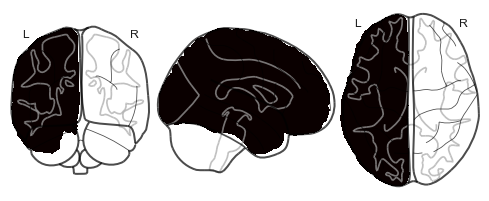

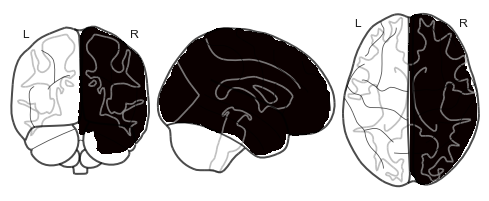

In [8]:
# In the volumetric version of Cole Atlas, left hemisphere parcels go from 1 to 180
# and right hemisphere parcels from 201 to 380
plotting.plot_glass_brain(image.math_img("(img>0)*(img<200)", img = cole_vol_img))
plotting.plot_glass_brain(image.math_img("img>200", img = cole_vol_img))

Load and define a few things needed for plotting the local connectome weight maps

In [9]:
# load the MNI152 T1 template
mni152_template = datasets.load_mni152_template()

# Load local connectome coordinates in this template
mni_location = np.loadtxt(opj("../data", "local_connectome_mni_coordinates.txt"), dtype=np.int16)

In [10]:
# Atlas of white matter tracts (Yeh 2018). This is just for tract-wise average weights for supp. material
tract_atlas = nib.load(opj("../data" ,'HCP842_tractography.nii.gz'))
tract_atlas_labels = pd.read_csv(opj("../data", 'HCP842_tractography.txt'), header=None, sep="\t").iloc[:,1]

Just for visualisation, plot the masks for the 10 first tracts

In [12]:
#CNVII_L
tract_atlas_labels.head(10)

0          Acoustic_Radiation_L
1          Acoustic_Radiation_R
2    Cortico_Striatal_Pathway_L
3    Cortico_Striatal_Pathway_R
4        Cortico_Spinal_Tract_L
5        Cortico_Spinal_Tract_R
6     Corticothalamic_Pathway_L
7     Corticothalamic_Pathway_R
8                      Fornix_L
9                      Fornix_R
Name: 1, dtype: object

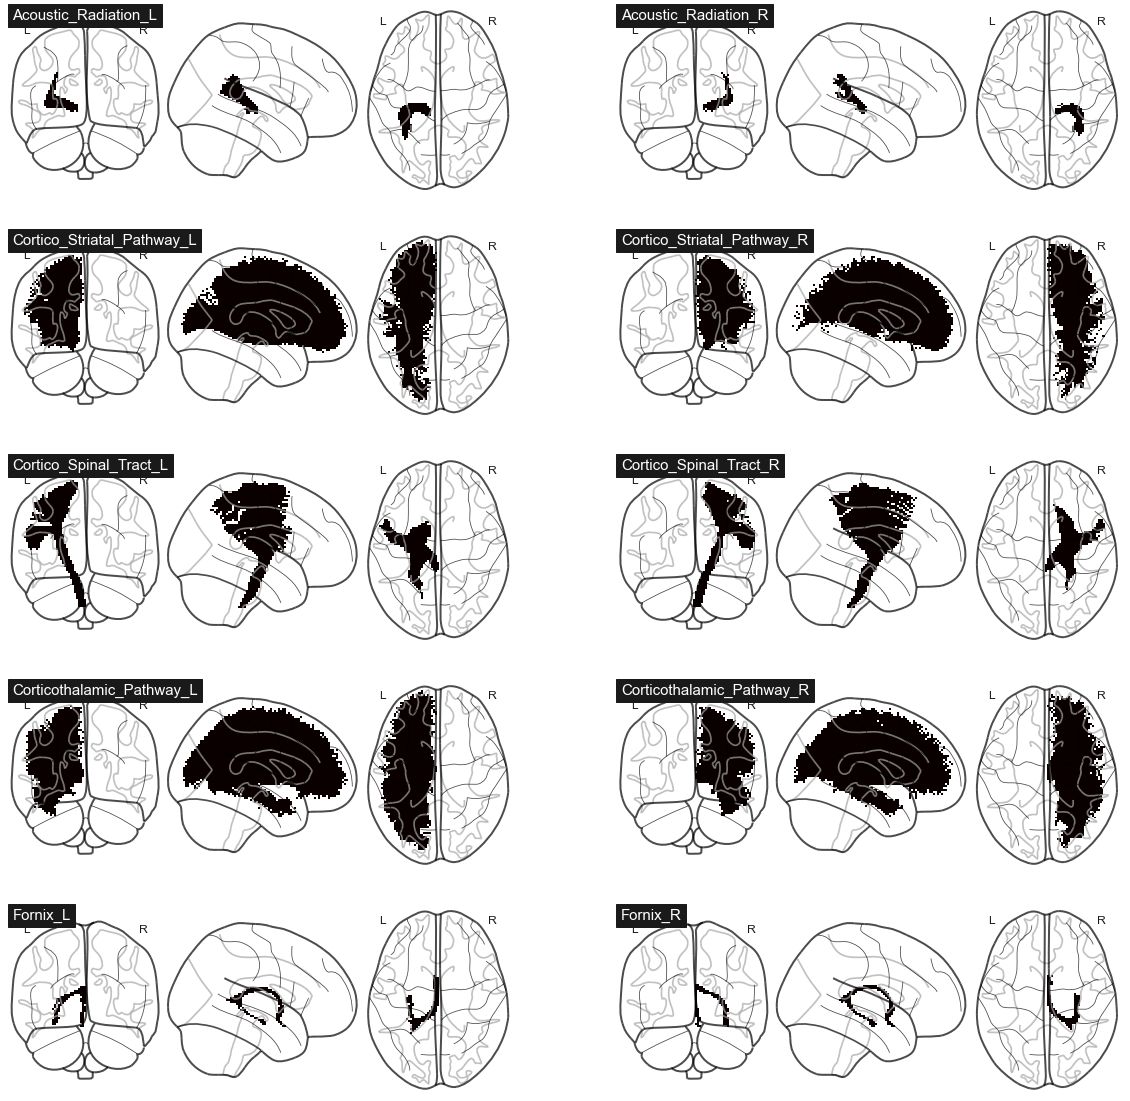

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(20, 20))
axs = axs.flatten()
for ii in range(10):

    source_img = image.index_img(tract_atlas, ii)
    plotting.plot_glass_brain(image.resample_to_img(source_img, mni152_template, interpolation='nearest'), 
                              axes=axs[ii], title = tract_atlas_labels[ii]
                             )

Some further definitions for their use througout the manuscript

In [14]:
# Name of test scores
score_names = ['Cognitive Function Composite',
               'Fluid Cognition Composite', 
               'Crystallized Cognition Composite', 
               'Short Penn CPT Sensitivity', 
               'Delay Discounting:\n AUC for Discounting of $200', 
               'Penn Word Memory: \n Total Number of Correct Responses', 
               'Penn Line Orientation: \n Total Number Correct']
# Name of single-channels
modality_names = ['RESTING-STATE \n CONNECTIVITY', 'CORTICAL \n SURFACE', 
                  'CORTICAL \n THICKNESS', 'SUBCORTICAL \n VOLUME', 'LOCAL \n CONNECTOME']

n_scores = len(score_names)
n_mods = len(modality_names)

Here some operations for plotting the local connectome phenotypes

In [20]:
#Pass mni coordinates to voxel coordinates
def from_mni_to_voxel(x, y, z):

    origin = [45, 63, 36]; #% [X Y Z]

    vs = 2
    x= origin[0] - x/vs
    y= y/vs + origin[1]
    z= z/vs + origin[2]

    return x, y, z

#compute the local connectome fingreprint coordinates into voxel system of reference
voxel_location = np.array([from_mni_to_voxel(x, y, z) for x, y, z in mni_location])

# Count repeated voxels to latter average on the local connectome feature weights
rep_img = np.zeros_like(mni152_template.get_fdata())

for ii, (x, y, z) in enumerate(voxel_location.astype(int)):
    rep_img[x, y, z] += 1
    
x_rep, y_rep, z_rep =  np.nonzero(rep_img)

Create folders where we are going to save the phenotype maps as pngs and the nifti images of these for NeuroVault

In [13]:
for score_name in ['CogTotalComp_Unadj', 
                   'CogFluidComp_Unadj',
                   'CogCrystalComp_Unadj',  
                   'DDisc_AUC_200',
                   'VSPLOT_TC']:
    
    plot_folder = Path(opj('../plots/R1', 'neurophenotypes', score_name))
    plot_folder.mkdir(parents=True, exist_ok=True)
    
    plot_folder = Path(opj('../images/R1', score_name))
    plot_folder.mkdir(parents=True, exist_ok=True)

# FUNCTIONAL CONNECTIVITY

In [14]:
scores_conn = ['CogTotalComp_Unadj', 'CogFluidComp_Unadj']

Some functions for plotting

In [15]:
def fc_figure(fcon_mat):
    
    """ make Functional Connectome figure """
    
    import matplotlib as mpl

    n = fcon_mat.shape[0]
    fc_mat_sorted = fcon_mat[indsort,:][:, indsort.T]
    
    thr = np.quantile(np.abs(fc_mat_sorted[np.triu_indices(n, k=1)]), q=0.95)
    thr=0
    fc_mat_sorted = fc_mat_sorted*(np.abs(fc_mat_sorted)>thr)
    
    # max value use for symmatric matrix
    
    absmax = np.max(np.abs(fc_mat_sorted))
    
    colors = mpl.colors.TwoSlopeNorm(vmin=-absmax, 
                                      vcenter=0, 
                                      vmax= absmax)
    #colors = mpl.colors.TwoSlopeNorm(vmin=np.min(fc_mat_sorted), 
     #                                 vcenter=0, 
      #                                vmax= np.max(fc_mat_sorted))
    upper_idxs = np.triu_indices(n, k=1)
    lower_idxs = np.tril_indices(n, k=-1)
    foo = np.zeros_like(fc_mat_sorted)
    
    upper = fc_mat_sorted*(fc_mat_sorted>0)
    lower = fc_mat_sorted*(fc_mat_sorted<0)
    
    foo[upper_idxs] = upper[upper_idxs]
    foo[lower_idxs] = lower[lower_idxs]
    #mask = np.tri(fc_mat_sorted.shape[0]).T
    #fc_mask = np.ma.array(fc_mat_sorted[indsort,:][:, indsort.T], mask=mask)

    fig, ax = plt.subplots( figsize=(10,10))
    divider = make_axes_locatable(ax)
    yhax = divider.append_axes("left", size=1, pad=-0.4)
    xhax = divider.append_axes("top", size=1, pad=-0.4)

    im = ax.imshow(fc_mat_sorted, aspect='equal', cmap=plt.cm.RdBu_r, norm=colors)

    yhax.imshow(netassignments[indsort].astype(int).reshape(-1, 1), aspect=0.05,
                cmap=rsn_cmap)
    yhax.set_xticks([])
    yhax.set_yticks([])
    xhax.imshow(netassignments[indsort].astype(int).reshape(1, -1), aspect=1/0.05,
                cmap=rsn_cmap)
    xhax.set_xticks([])
    xhax.set_yticks([])

    unique_rsn, vcount = np.unique(netassignments, return_counts=True)

    y_o = 0

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlabel("Regions", fontsize = 25)
    ax.tick_params(axis="x", labelsize=15)
    yhax.set_axis_off()
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=.04, pad=0.1)
    cbar.ax.set_xlabel('LASSO-PCR Weights', fontsize=20, fontweight='bold', labelpad=10)
    cbar.ax.tick_params(labelsize=12)
    return fig

def get_mean_rsn(conn_mat):
    
    """ Function to compute the mean weights 
        within and between intrinsic networks """
    
    rsn_weights = np.zeros((12, 12))
    n_rsn = 12
    #Construct the resting state network of mean weights
    for ii in range(n_rsn):
        for jj in range(ii, n_rsn):
            rsn_mat = conn_mat[netassignments==ii+1,:][:, netassignments==jj+1]

            #if within network, take upper triangular
            if ii==jj:
                rsn_mat = conn_mat[np.triu_indices(rsn_mat.shape[0], k=1)]

            rsn_weights[ii, jj] = np.mean(rsn_mat)
            rsn_weights[jj, ii] = rsn_weights[ii, jj]
    return rsn_weights

Take the highest weights and plot

In [16]:
def map_weights_cole(strength):
    cole_vol_data = cole_vol_img.get_fdata()
    weight_data = np.zeros((cole_vol_img.shape))

    # Left hemisphere
    for (ii, w) in zip(range(1, 181), strength[:180]):
        weight_data[cole_vol_data==ii] = w

    # Right hemisphere
    for (ii, w) in zip(range(201, 381), strength[181:360]):
        weight_data[cole_vol_data==ii] = w

    weights_in_vol = image.new_img_like(cole_vol_img, data=weight_data)
    
    return weights_in_vol

In [85]:
w_conn = f[scores_conn[1]]['activation_pattern_CONNECTOME'][:]
thr = np.percentile(abs(w_conn), q=99.)
mask = abs(w_conn)>thr

w_mask = np.sum(np.abs(squareform(w_conn*mask)), axis=1)
w_mask = np.squeeze(maxabs_scale(w_mask[:, None]))


In [17]:
for score_name in scores_conn:
    
    plot_folder = Path(opj('../plots/R1/', 'neurophenotypes', score_name))
    plot_folder.mkdir(parents=True, exist_ok=True)
    plot_folder = plot_folder.absolute().as_posix()
    
    w_conn = f[score_name]['activation_pattern_CONNECTOME'][:]

    thr = np.percentile(abs(w_conn), q=99.)
    mask = abs(w_conn)>thr

    w_mask = np.sum(np.abs(squareform(w_conn*mask)), axis=1)
    w_mask = np.squeeze(maxabs_scale(w_mask[:, None]))

    np.savetxt(opj(plot_folder, score_name +'_resting_strength_map.txt'), w_mask)
    
    # In this command we are going to map these weights in the parcellation
    cmd = ["wb_command", 
           "-cifti-convert", 
           "-from-text", 
           opj(plot_folder, score_name +'_resting_strength_map.txt'), 
           cole_pscalar_img,
           opj(plot_folder, score_name +'_resting_strength_map.pscalar.nii')
          ]
    
    subprocess.run(cmd)

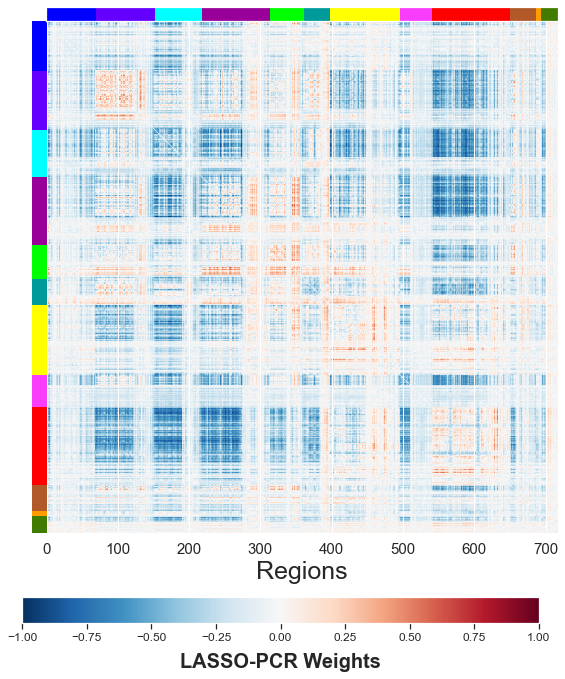

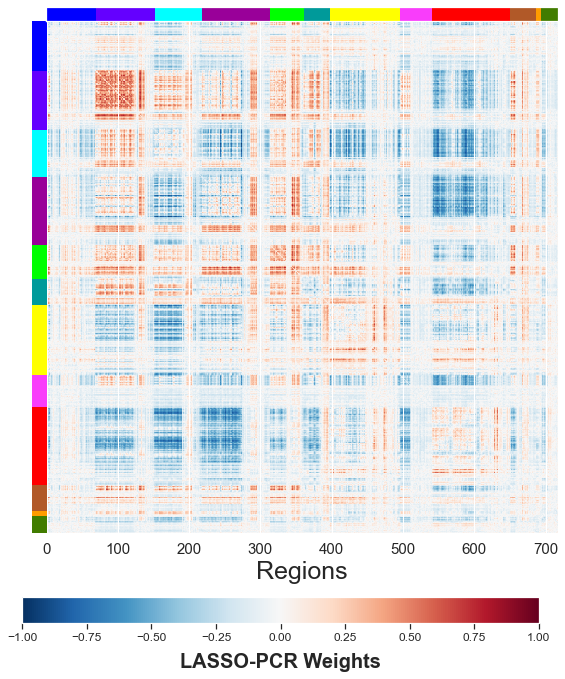

In [18]:
for score_name in scores_conn:
    
    plot_folder = Path(opj('../plots/R1/', 'neurophenotypes', score_name))
    plot_folder.mkdir(parents=True, exist_ok=True)
    plot_folder = plot_folder.absolute().as_posix()
    
    w_conn = f[score_name]['activation_pattern_CONNECTOME'][:]
    w_conn= np.squeeze(maxabs_scale(w_conn[:, None]))
    
    fcon_mat = squareform(w_conn) #compute_fcon(w_conn)

    fig = fc_figure(fcon_mat)
    plt.tight_layout()
    plt.savefig(opj(plot_folder, 'functional_mat.png'), dpi=300)

One thing that we see in Fluid Intelliegence is an increase in the positive associations

In [19]:
for score_name in scores_conn:
    print(sum(f[score_name]['activation_pattern_CONNECTOME'][:]>0))

70103
103408


Save these networks to a table to plot using circos

In [20]:
import numpy.ma as ma

In [21]:
def get_mean_rsn(conn_mat):
    
    """ Function to compute the mean weights 
        within and between intrinsic networks """
    
    rsn_weights = np.zeros((12, 12))
    n_rsn = 12
    #Construct the resting state network of mean weights
    for ii in range(n_rsn):
        for jj in range(ii, n_rsn):
                rsn_weights[ii, jj] = np.nanmean(conn_mat[netassignments==(ii+1),:][:, netassignments==(jj+1)])
                rsn_weights[jj, ii] =  rsn_weights[ii,jj]
    return rsn_weights

In [22]:
def get_rsn_weights(conn_mat):
    
    """ Function to compute the mean weights 
        within and between intrinsic networks """
    
    rsn_weights = []
    n_rsn = 12
    #Construct the resting state network of mean weights
    for ii in range(n_rsn):
        weights = conn_mat[netassignments==(ii+1),:]
        rsn_weights.append(weights[~np.isnan(weights)].flatten())
        
    return rsn_weights

In [23]:
def plot_rsn_weights(mean_pos_rsn, mean_neg_rsn):
    
    """ Function to plot the mean weights per RSN as barplots """
    
    from matplotlib.ticker import FormatStrFormatter
    
    x  = []
    x += list(np.arange(-15, -3)) # x-position for negative weights
    x += list(np.arange(1, 13)) # x-position for positive weights
    
    y  = [] 
    y += list(mean_neg_rsn[np.argsort(mean_neg_rsn)]) # y-position for negative weights
    y += list(mean_pos_rsn[np.argsort(mean_pos_rsn)]) # y-position for negative weights
    
    c  = []
    c += list(np.array(rsn_norm_colours)[np.argsort(mean_neg_rsn)]) # colours for negative weights 
    c += list(np.array(rsn_norm_colours)[np.argsort(mean_pos_rsn)]) # colours for positive weights 
    y = np.array(y)

    min_y = min(y)
    max_y = max(y)
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax.bar(x,y, color=c, alpha=0.7)
    ax.scatter(x, y, c=c, s=200)

    ax.spines['left'].set_position('center')
    #ax.spines['bottom'].set_position(('axes', 0.455))
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.set_xticks([]) 
    ax.set_yticks([])    
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    #ax.yaxis.set_major_formatter(formatter) 

    y_min, y_max = plt.gca().get_ylim()
    #ax.tick_params("y", labelsize=20)
    #ax.text( -1.2, y_min, s=r'$\times 10^{-4}$', size=20)
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    return fig.tight_layout()
    

# LOCAL CONNECTOME

Plotting **local connectome** neurophenotype for Cogntive composite, Fluig Cognition score, Crystallized Cognitive score, and Penn Line orientation

In [15]:
scores_locc = ['CogTotalComp_Unadj',
               'CogFluidComp_Unadj',
               'CogCrystalComp_Unadj',
               'VSPLOT_TC', 
               'DDisc_AUC_200']

In [18]:
def compute_loc_in_mni(lc_weights):
    
    """ set local connectome weights in MNI template """
    
    lc_img = np.zeros_like(mni152_template.get_fdata())
    
    # Add weights into to map location
    for ii, (x, y, z) in enumerate(voxel_location.astype(int)):
        lc_img[x, y, z] += lc_weights[ii]
    
    #Average over repeated voxels
    for x, y, z in zip(x_rep, y_rep, z_rep):
        lc_img[x,y,z] = lc_img[x, y, z]/rep_img[x, y, z]
        
    return lc_img

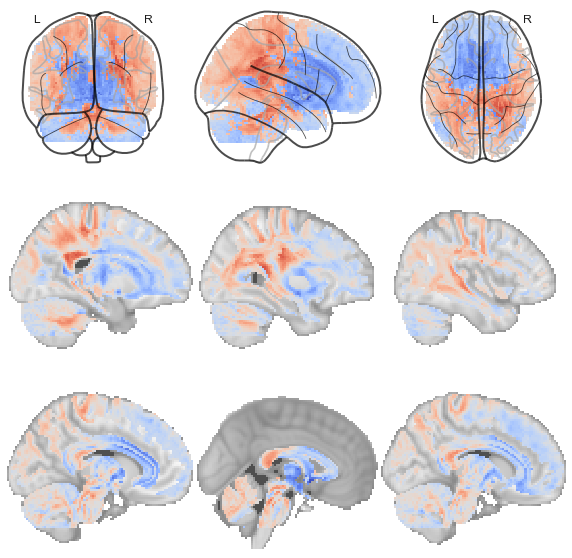

In [78]:
fig, axs = plt.subplots(nrows=3, figsize=(10,10))
# Plot this and save it to plot folder
plotting.plot_glass_brain(loc_mni_image, 
                          cmap=plt.cm.coolwarm,
                          plot_abs=False,
                          colorbar=False,
                          symmetric_cbar=True,
                          display_mode = 'ortho', 
                         axes=axs[0])

plotting.plot_stat_map(loc_mni_image, 
                       cmap=plt.cm.coolwarm,
                       colorbar=False,
                       annotate=False,
                       symmetric_cbar=True,
                       display_mode="x", 
                       vmax=1,
                       cut_coords=(40, 30, 20), 
                       axes=axs[1])

plotting.plot_stat_map(loc_mni_image, 
                       cmap=plt.cm.coolwarm,
                       colorbar=False,
                       annotate=False,
                       symmetric_cbar=True,
                       display_mode="x", 
                       vmax=1,
                       cut_coords=(10, 0, -10), 
                       axes=axs[2])

<ipython-input-92-9fd9a7d75c49>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-92-9fd9a7d75c49>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-92-9fd9a7d75c49>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-92-9fd9a7d75c49>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-92-9fd9a7d75c49>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


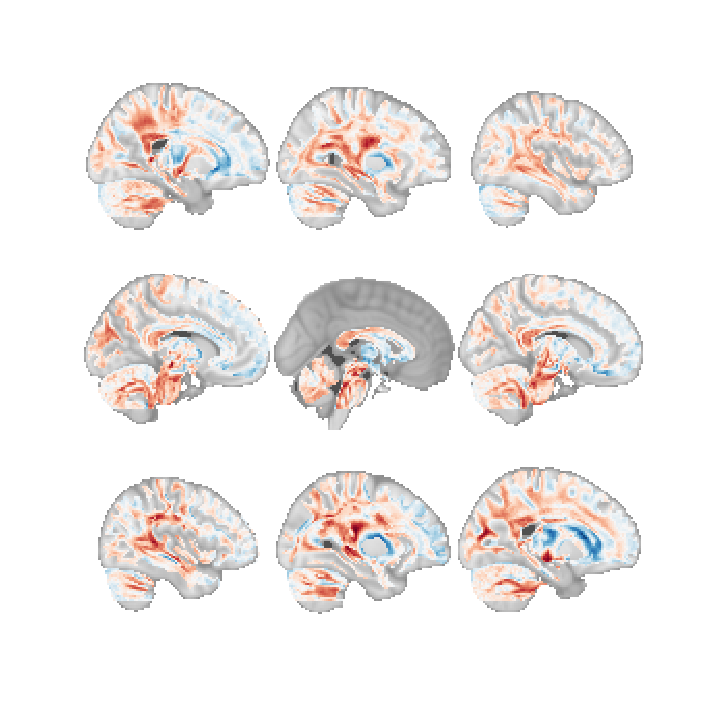

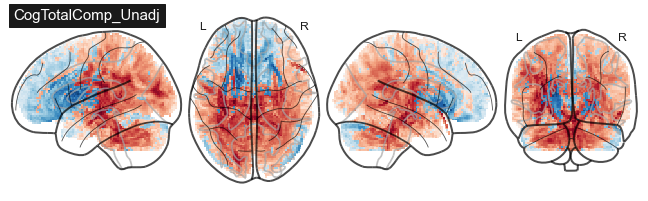

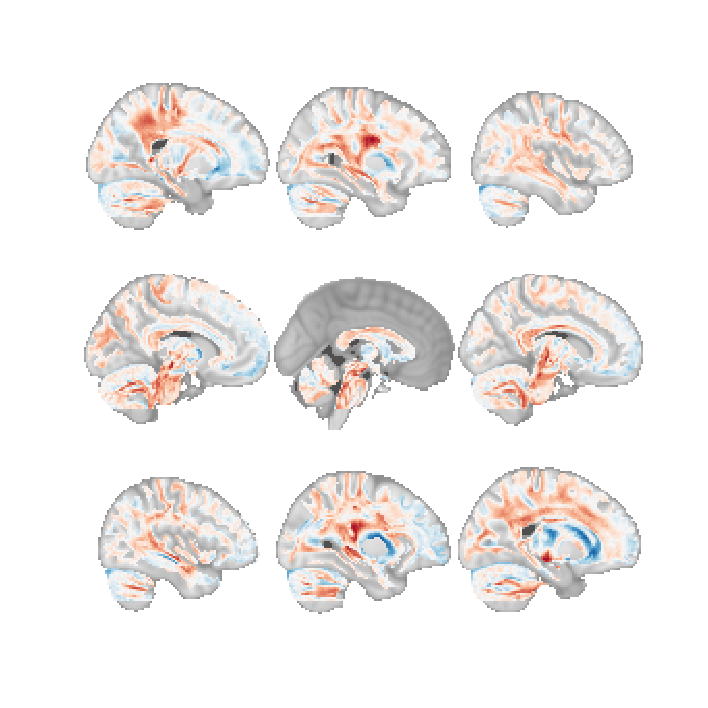

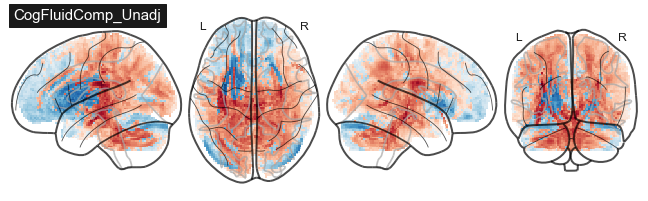

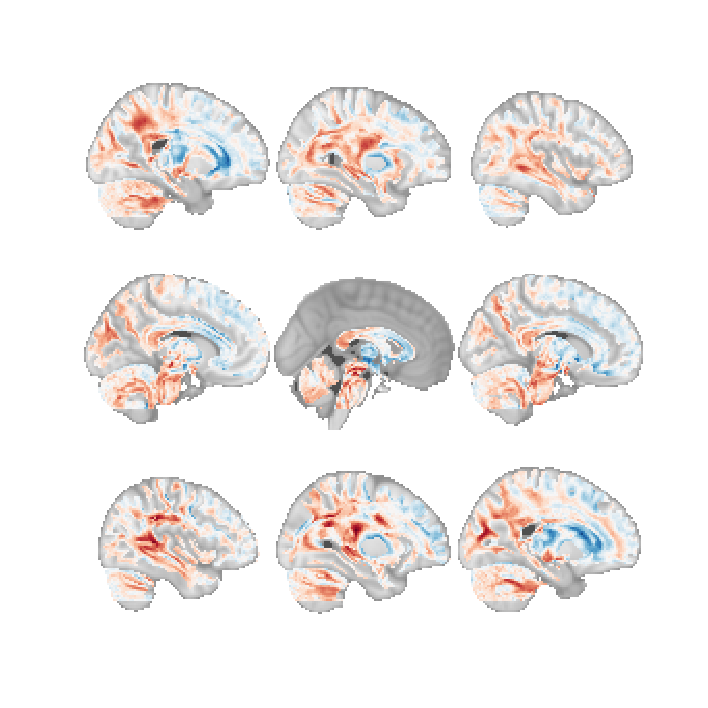

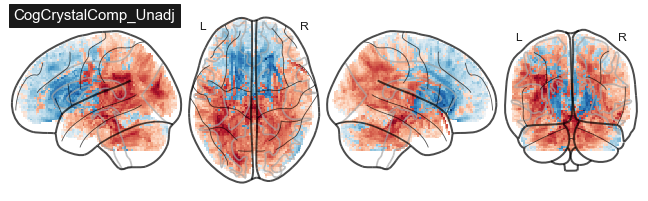

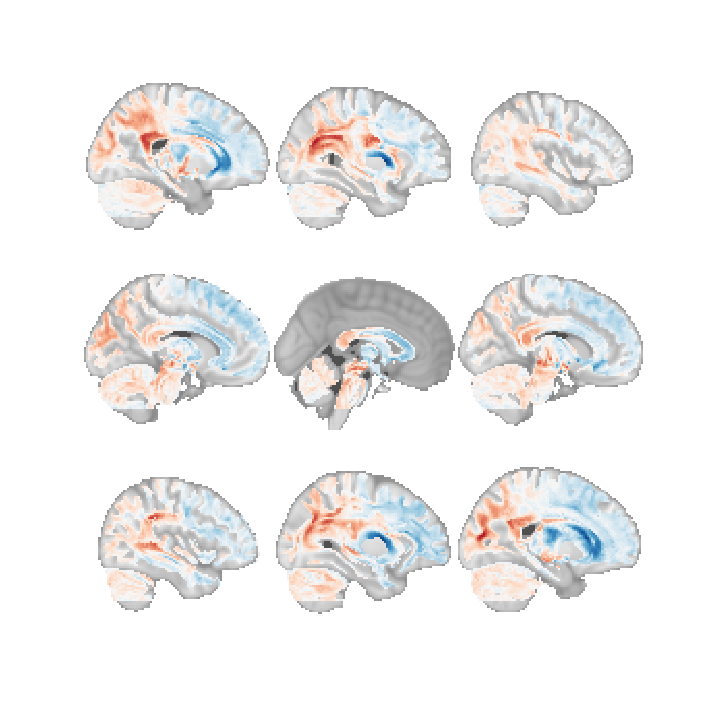

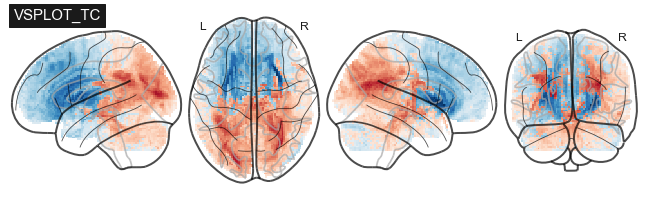

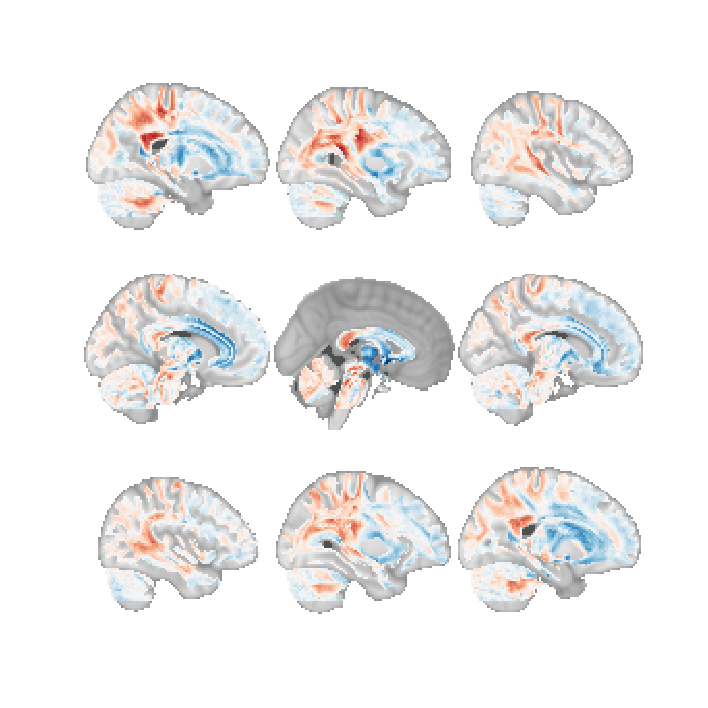

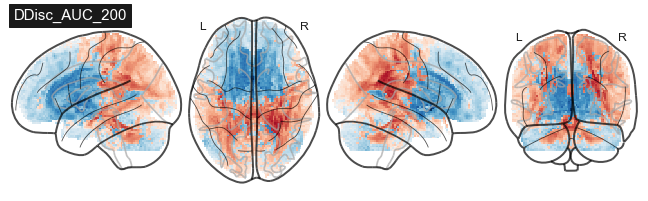

In [92]:
for score_name in scores_locc:
    
    # Plot folder
    plot_folder = Path(opj('../plots/R1', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()
    
    # Load weights
    w_loc = f[score_name]['activation_pattern_LOCAL_CONN'][:]
    w_loc = np.squeeze(maxabs_scale(w_loc[:, None]))

    # Compute weighs in mni space
    loc_map = compute_loc_in_mni(w_loc)
    
    # Create an image in standard space with this data 
    loc_mni_image = image.new_img_like(mni152_template, loc_map)
    
    # Save to this image to upload to NeuroVault
    loc_mni_image.to_filename(opj("../images/R1", score_name, "%s_local_connectome_activation_pattern.nii.gz" % score_name))
    
    fig, axs = plt.subplots(nrows=3, figsize=(10,10))
    plotting.plot_stat_map(loc_mni_image, 
                           cmap=plt.cm.RdBu_r,
                           colorbar=False,
                           annotate=False,
                           symmetric_cbar=True,
                           display_mode="x", 
                           vmax=1,
                           cut_coords=(40, 30, 20), 
                           axes=axs[0])
    
    plotting.plot_stat_map(loc_mni_image, 
                           cmap=plt.cm.RdBu_r,
                           colorbar=False,
                           annotate=False,
                           symmetric_cbar=True,
                           display_mode="x", 
                           vmax=1,
                           cut_coords=(10, 0, -10), 
                           axes=axs[1])
    
    plotting.plot_stat_map(loc_mni_image, 
                           cmap=plt.cm.RdBu_r,
                           annotate=False,
                           colorbar=False,
                           symmetric_cbar=True,
                           display_mode="x", 
                           vmax=1,
                           cut_coords=(-20, -30, -40),
                           axes=axs[2])
    plt.tight_layout()
    plt.savefig(opj(plot_folder, 'local_connectome.png'), dpi=300)
    plt.savefig(opj(plot_folder, 'local_connectome.svg'), dpi=300)
    
    # Plot this and save it to plot folder
    plotting.plot_glass_brain(loc_mni_image, 
                              cmap=plt.cm.RdBu_r,
                              plot_abs=False,
                              colorbar=False,
                              symmetric_cbar=True,
                              display_mode = 'lzry', 
                              title = score_name)

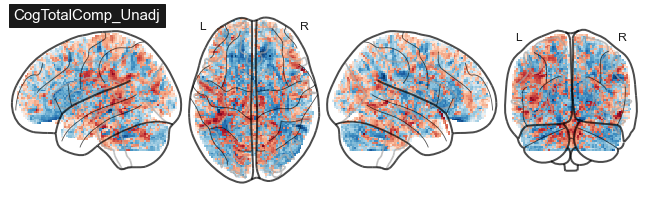

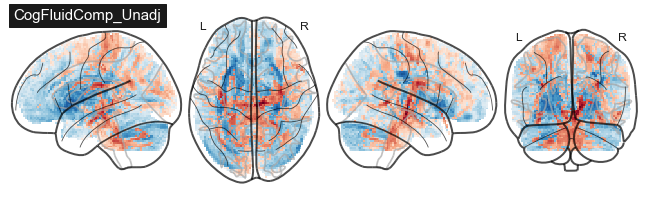

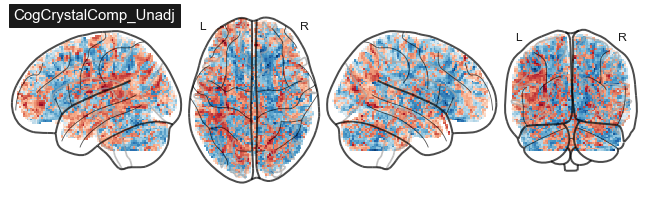

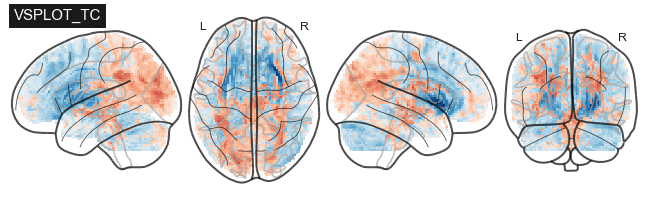

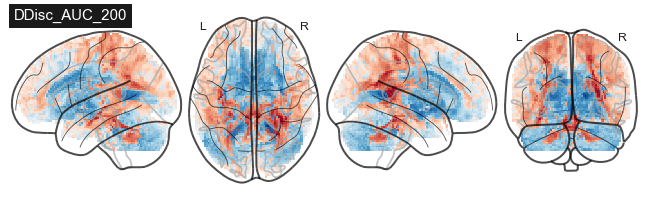

In [24]:
# save prediction_patterns nifti
for score_name in scores_locc:
    
    # Plot folder
    plot_folder = Path(opj('../plots/R1', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()
    
    # Load weights
    w_loc = f[score_name]['prediction_pattern_LOCAL_CONN'][:]
    w_loc = np.squeeze(maxabs_scale(w_loc[:, None]))
    
    # Compute weighs in mni space
    loc_map = compute_loc_in_mni(w_loc)
    
    # Create an image in standard space with this data 
    loc_mni_image = image.new_img_like(mni152_template, loc_map)
    
    # Save to this image to upload to NeuroVault
    loc_mni_image.to_filename(opj("../images/R1", score_name, "%s_local_connectome_prediction_pattern.nii.gz" % score_name))
    
    # Plot this and save it to plot folder
    plotting.plot_glass_brain(loc_mni_image, 
                              cmap=plt.cm.RdBu_r,
                              plot_abs=False,
                              colorbar=False,
                              symmetric_cbar=True,
                              display_mode = 'lzry',
                              title = score_name)

Compute the tract-wise averaged positive and negative weights using an atlas of white matter tracts (Yeh 2018).

In [25]:
columns = scores_locc

# We are going to separate into negative and positive weights
loc_pos_mean_atlas =  pd.DataFrame({}, columns=columns)
loc_neg_mean_atlas =  pd.DataFrame({}, columns=columns)

for ii in range(tract_atlas.shape[3]):
    tract_img = image.index_img(tract_atlas, ii)

    tract_img_152 = image.resample_to_img(tract_img, 
                                          mni152_template, 
                                          interpolation='nearest')
    
    tract_name = tract_atlas_labels.to_list()[ii]
    
    pos_score_values = []
    neg_score_values = []
    
    for score_name in columns:

        w_loc = f[score_name]['activation_pattern_LOCAL_CONN'][:]
        loc_map = compute_loc_in_mni(w_loc)

        loc_152 = image.new_img_like(mni152_template, loc_map)
        
        loc_tract_data = image.math_img('img1*img2', 
                                       img1=loc_152, 
                                       img2=tract_img_152).get_fdata().copy()
        
        # You could use here maybe masked arrays
        pos_score_values.append(np.mean(loc_tract_data[loc_tract_data>0]))
        neg_score_values.append(np.mean(abs(loc_tract_data[loc_tract_data<0])))
        
    loc_pos_mean_atlas = loc_pos_mean_atlas.append(pd.DataFrame([pos_score_values], 
                                                                columns=columns))
    loc_neg_mean_atlas = loc_neg_mean_atlas.append(pd.DataFrame([neg_score_values], 
                                                                columns=columns))
    
    #If warning, that means that there's no weights on that tract

/home/javi/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

In [26]:
loc_pos_mean_atlas.index=tract_atlas_labels
loc_pos_mean_atlas.index.name = 'Tracts'
loc_neg_mean_atlas.index=tract_atlas_labels
loc_neg_mean_atlas.index.name = 'Tracts'

Show the first 10 tracts with the largest positive and negative weights

In [27]:
tract_atlas.shape

(157, 189, 136, 80)

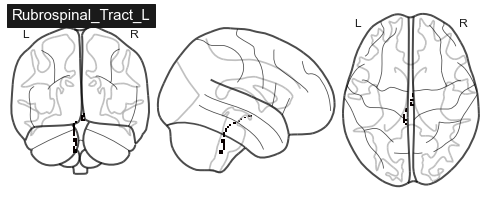

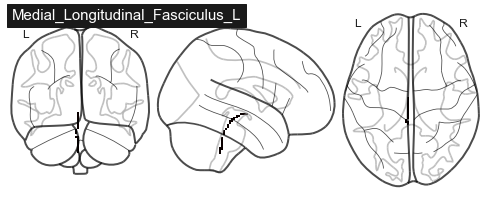

In [34]:
ii = np.where(tract_atlas_labels.values=="Rubrospinal_Tract_L")[0][0]
source_img = image.index_img(tract_atlas, ii)
plotting.plot_glass_brain(image.resample_to_img(source_img, mni152_template, interpolation='nearest'), 
                          title = tract_atlas_labels[ii]
                         )

ii = np.where(tract_atlas_labels.values=="Medial_Longitudinal_Fasciculus_L")[0][0]
source_img = image.index_img(tract_atlas, ii)
plotting.plot_glass_brain(image.resample_to_img(source_img, mni152_template, interpolation='nearest'), 
                          title = tract_atlas_labels[ii]
                         )

In [94]:
# Positive weights
for col in loc_pos_mean_atlas.columns:
    print("--------------------")
    print(col)
    print("--------------------")
    print(loc_pos_mean_atlas.loc[:,col].sort_values(ascending=False)[:10])
    print(" ")

--------------------
CogTotalComp_Unadj
--------------------
Tracts
CNVII_L                             0.777903
CNX_L                               0.765704
Rubrospinal_Tract_L                 0.754538
Medial_Longitudinal_Fasciculus_L    0.744232
CNVII_R                             0.740895
Rubrospinal_Tract_R                 0.726238
CNX_R                               0.717440
Central_Tegmental_Tract_R           0.713681
CNIII_R                             0.712092
Central_Tegmental_Tract_L           0.696813
Name: CogTotalComp_Unadj, dtype: float64
 
--------------------
CogFluidComp_Unadj
--------------------
Tracts
Central_Tegmental_Tract_R           0.405429
Rubrospinal_Tract_R                 0.404685
Medial_Longitudinal_Fasciculus_L    0.370437
CNVII_L                             0.369052
Rubrospinal_Tract_L                 0.367504
Central_Tegmental_Tract_L           0.354560
CNVII_R                             0.342915
CNIII_R                             0.332936
CNX_L      

In [95]:
# Negative weights
for col in loc_neg_mean_atlas.columns:
    print("--------------------")
    print(col)
    print("--------------------")
    print(-1*loc_neg_mean_atlas.loc[:,col].sort_values(ascending=False)[:10])
    print(" ")

--------------------
CogTotalComp_Unadj
--------------------
Tracts
Medial_Lemniscus_L                       -0.392488
Medial_Longitudinal_Fasciculus_R         -0.363267
Medial_Lemniscus_R                       -0.347065
Cingulum_L                               -0.325608
Inferior_Fronto_Occipital_Fasciculus_L   -0.320570
Extreme_Capsule_L                        -0.315746
Anterior_Commissure                      -0.302182
Superior_Cerebellar_Peduncle             -0.300795
Optic_Radiation_L                        -0.298744
Uncinate_Fasciculus_L                    -0.294466
Name: CogTotalComp_Unadj, dtype: float64
 
--------------------
CogFluidComp_Unadj
--------------------
Tracts
Central_Tegmental_Tract_L                -0.240468
Inferior_Fronto_Occipital_Fasciculus_L   -0.194172
Extreme_Capsule_L                        -0.189892
Medial_Longitudinal_Fasciculus_R         -0.188051
Medial_Lemniscus_L                       -0.186478
Optic_Radiation_L                        -0.170066
Uncin

Create a latex table from these results to copy to the manuscript

In [96]:
#Positive weights
print((np.round(loc_pos_mean_atlas, 3)).to_latex(index=True, na_rep="-", 
                                                       longtable=True, 
                                                       caption='mean positive weights'))

\begin{longtable}{lrrrrr}
\caption{mean positive weights}\\
\toprule
{} &  CogTotalComp\_Unadj &  CogFluidComp\_Unadj &  CogCrystalComp\_Unadj &  VSPLOT\_TC &  DDisc\_AUC\_200 \\
Tracts                                 &                     &                     &                       &            &                \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
Acoustic\_Radiation\_L                   &               0.647 &               0.270 &                 0.398 &      0.084 &          0.002 \\
Acoustic\_Radiation\_R                   &               0.541 &               0.258 &                 0.296 &      0.081 &          0.002 \\
Cortico\_Striatal\_Pathway\_L             &               0.328 &               0.170 &                 0.204 &      0.063 &          0.002 \\
Cortico\_Striatal\_Pathway\_R             &               0.283 &               0.151 &                 0.184 &      0.066 &          0

In [97]:
# Negative weights
print((np.round(loc_neg_mean_atlas, 3)).to_latex(index=True, na_rep="-", 
                                          longtable=True, 
                                          caption='mean negative weights'))

\begin{longtable}{lrrrrr}
\caption{mean negative weights}\\
\toprule
{} &  CogTotalComp\_Unadj &  CogFluidComp\_Unadj &  CogCrystalComp\_Unadj &  VSPLOT\_TC &  DDisc\_AUC\_200 \\
Tracts                                 &                     &                     &                       &            &                \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
Acoustic\_Radiation\_L                   &               0.208 &               0.083 &                 0.161 &      0.048 &          0.001 \\
Acoustic\_Radiation\_R                   &               0.280 &               0.138 &                 0.187 &      0.046 &          0.001 \\
Cortico\_Striatal\_Pathway\_L             &               0.291 &               0.154 &                 0.187 &      0.081 &          0.002 \\
Cortico\_Striatal\_Pathway\_R             &               0.216 &               0.111 &                 0.160 &      0.061 &          0

# CORTICAL SURFACE AREA

For Global Cogntive composite, Fluig Cognitive score, Crystallized Cognitive score, Delay Discounting and Penn Line orientation, pass **cortical surface area** neurophenotype to a txt file to then plot it using *wb_view* and save it as a nifti file for NeuroVault.

In [35]:
scores_surf=['CogTotalComp_Unadj',
             'CogFluidComp_Unadj', 
             'CogCrystalComp_Unadj',
             'DDisc_AUC_200',
             'VSPLOT_TC']

In [30]:
# Retrieve the parcellation label data in the volume version
cole_vol_data = cole_vol_img.get_fdata()

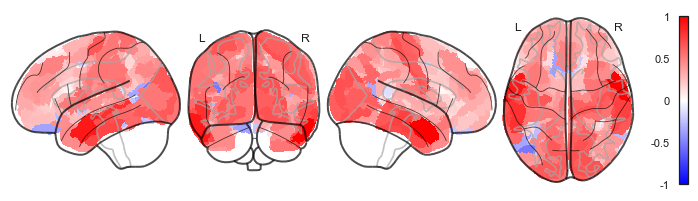

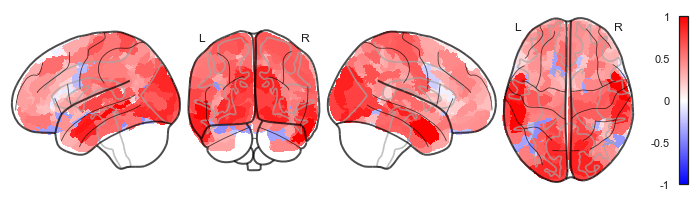

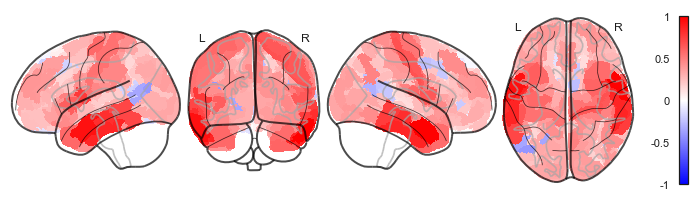

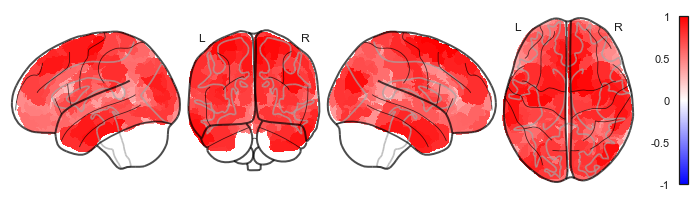

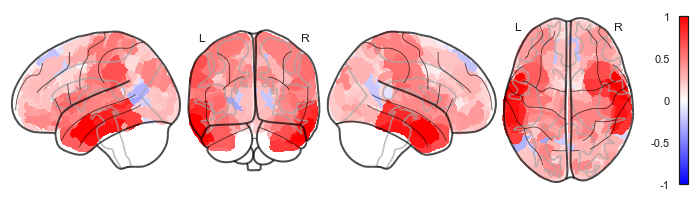

In [31]:
for score_name in scores_surf:
    
    # Define plot folder
    plot_folder = Path(opj('../plots/R1/', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()
    
    w_surface = f[score_name]['activation_pattern_SURFACE'][:]
    w_surface = np.squeeze(maxabs_scale(w_surface[:, None]))

    # Define a data frame with these weights and their labels according to Cole
    weights_df = pd.DataFrame({'parcel_label': parcel_labels[:360], 'weights': w_surface})
    
    # Save an additional txt file with the name of the ROI and the thickness value
    weights_df.to_csv(opj(plot_folder, 
                          score_name +'_surface_activation_weights.txt'), sep = '\t', index=False)
    
    # save temp.txt adding zero values for subcortical parcels
    np.savetxt(opj(plot_folder, 'temp.txt'), np.concatenate((w_surface, 
                                                             np.zeros(718-len(w_surface)))))
    ## CIFTI FOR PLOTTING IN WB_VIEW ## 
    
    # In this command we are going to map these weights in the parcellation
    cmd = ["wb_command", 
           "-cifti-convert", 
           "-from-text", 
           opj(plot_folder, 'temp.txt'), 
           cole_pscalar_img,
           opj(plot_folder, score_name +'_surface_activation_weights.pscalar.nii')
          ]
    subprocess.run(cmd)
    
    os.remove(opj(plot_folder, 'temp.txt'))
    
    ## NIFTI FOR NEUROVAULT ## 
    
    # empty data where to map the weights in voxel space
    weight_data = np.zeros((cole_vol_img.shape))
    
    # Left hemisphere
    for (ii, w) in zip(range(1, 181), weights_df.iloc[:180, 1]):
        weight_data[cole_vol_data==ii] = w
        
    # Right hemisphere
    for (ii, w) in zip(range(201, 381), weights_df.iloc[180:, 1]):
        weight_data[cole_vol_data==ii] = w
        
    weights_in_vol = image.new_img_like(cole_vol_img, data=weight_data)
    # Save this to upload to neurovault
    weights_in_vol.to_filename(opj("../images/R1", 
                                   score_name, 
                                   "%s_surface_activation_weights.nii.gz" % score_name))
    
    plotting.plot_glass_brain(weights_in_vol, 
                              display_mode='lyrz', 
                              cmap=plt.cm.bwr, 
                              plot_abs=False, 
                              colorbar=True)

Show the most important positive and negative weights for each of these

In [36]:
for score_name in scores_surf:
    
    plot_folder = Path(opj('../plots/R1', 'neurophenotypes', score_name))
    
    print("---------------")
    print(score_name)
    print("---------------")
    print(pd.read_csv(opj(plot_folder, 
                          score_name +'_surface_activation_weights.txt'), sep = '\t').sort_values(by='weights', 
                                                                                     ascending=False).head(10))
    print(" ")
    print(pd.read_csv(opj(plot_folder, 
                          score_name +'_surface_activation_weights.txt'), sep = '\t').sort_values(by='weights').head(10))
    print("---------------")
    print(" ")

---------------
CogTotalComp_Unadj
---------------
                parcel_label   weights
311         Default-29_R-Ctx  1.000000
131         Default-67_L-Ctx  0.899095
129         Default-65_L-Ctx  0.806122
356  Frontoparietal-28_R-Ctx  0.749313
133         Default-68_L-Ctx  0.725428
313         Default-30_R-Ctx  0.710596
309         Default-27_R-Ctx  0.689713
176         Default-77_L-Ctx  0.683327
175         Default-76_L-Ctx  0.681713
184         Visual2-04_R-Ctx  0.674887
 
                      parcel_label   weights
140  Posterior-Multimodal-07_L-Ctx -0.527705
92                Default-59_L-Ctx -0.364888
139  Posterior-Multimodal-06_L-Ctx -0.347579
320  Posterior-Multimodal-04_R-Ctx -0.334768
156               Visual2-50_L-Ctx -0.303789
163               Default-74_L-Ctx -0.265991
319  Posterior-Multimodal-03_R-Ctx -0.265801
162               Visual2-54_L-Ctx -0.255894
118               Default-62_L-Ctx -0.236654
120               Visual1-05_L-Ctx -0.233573
---------------
 
-----

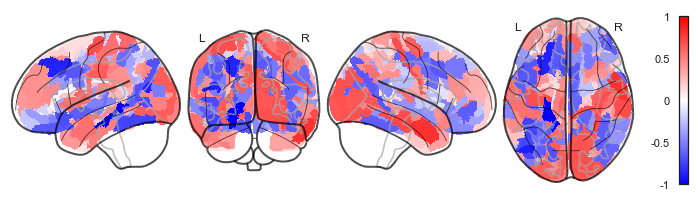

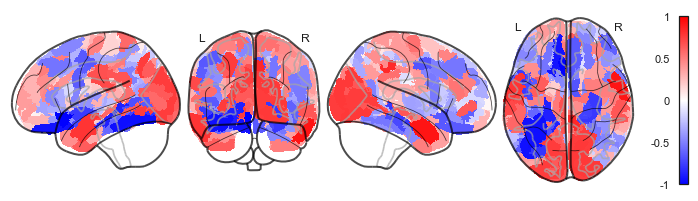

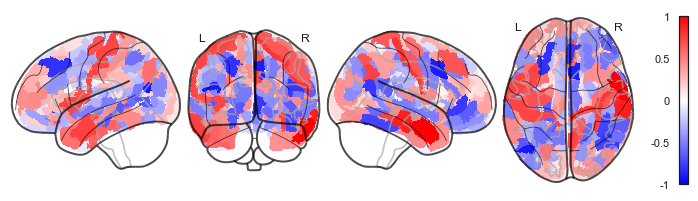

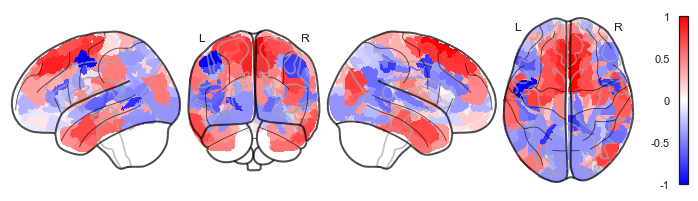

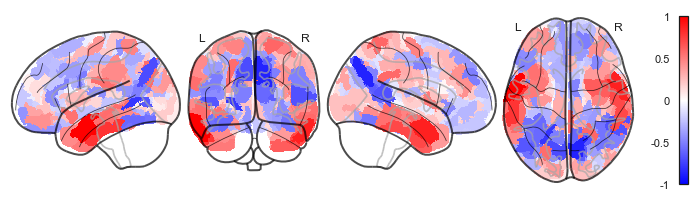

In [32]:
# Save nifti prediction_patterns 
for score_name in scores_surf:
    
    # Define plot folder
    plot_folder = Path(opj('../plots/R1/', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()

    w_surface = f[score_name]['prediction_pattern_SURFACE'][:]
    w_surface = np.squeeze(maxabs_scale(w_surface[:, None]))

    
    # Define a data frame with these weights and their labels according to Cole
    weights_df = pd.DataFrame({'parcel_label': parcel_labels[:360], 'weights': w_surface})
    
    
    ## NIFI FOR NEUROVAULT ## 
    
    # empty data where to map the weights in voxel space
    weight_data = np.zeros((cole_vol_img.shape))
    
    # Left hemisphere
    for (ii, w) in zip(range(1, 181), weights_df.iloc[:180, 1]):
        weight_data[cole_vol_data==ii] = w
        
    # Right hemisphere
    for (ii, w) in zip(range(201, 381), weights_df.iloc[180:, 1]):
        weight_data[cole_vol_data==ii] = w
        
    weights_in_vol = image.new_img_like(cole_vol_img, data=weight_data)
    # Save this to upload to neurovault
    weights_in_vol.to_filename(opj("../images/R1", 
                                   score_name, 
                                   "%s_surface_prediction_weights.nii.gz" % score_name))
    
    plotting.plot_glass_brain(weights_in_vol, 
                              display_mode='lyrz', 
                              cmap=plt.cm.bwr, 
                              plot_abs=False, 
                              colorbar=True)

# CORTICAL THICKNESS

For Global Cogntive composite, Fluig Cognitive score, Crystallized Cognitive score, Delay Discounting and Penn Line orientation, pass **cortical thickness** neurophenotype to a txt file to then plot it using *wb_view* and save it as a nifti file for NeuroVault.

In [99]:
scores_thic = ['CogTotalComp_Unadj','CogCrystalComp_Unadj', 'VSPLOT_TC']

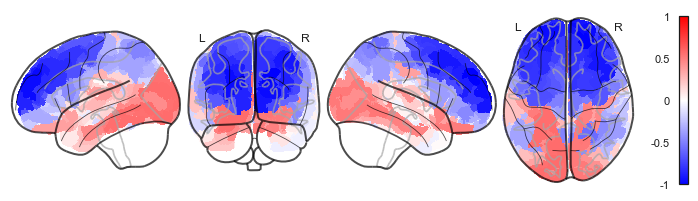

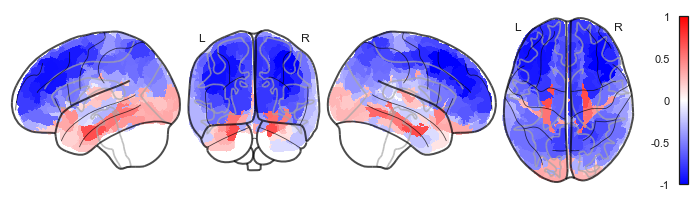

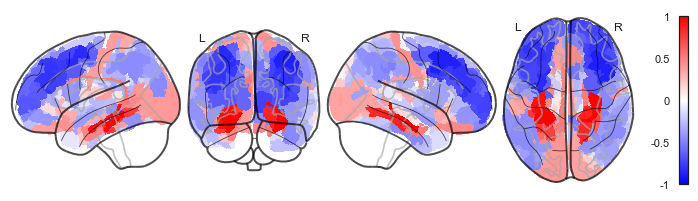

In [34]:
# Retrieve the parcellation label data in the volume version
cole_vol_data = cole_vol_img.get_fdata()

for score_name in scores_thic:
    
    # Define plot folder
    plot_folder = Path(opj('../plots/R1', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()
    
    w_thickness = f[score_name]['activation_pattern_THICKNESS'][:]
    w_thickness = np.squeeze(maxabs_scale(w_thickness[:, None]))
    
    # Define a data frame with these weights and their labels according to Cole
    weights_df = pd.DataFrame({'parcel_label': parcel_labels[:360], 'weights': w_thickness})
    
    # Save an additional txt file with the name of the ROI and the thickness value
    weights_df.to_csv(opj(plot_folder, 
                          score_name +'_thickness_activation_weights.txt'), sep = '\t', index=False)
    
    # save temp.txt adding zero values for subcortical parcels
    np.savetxt(opj(plot_folder, 'temp.txt'), np.concatenate((w_thickness, 
                                                             np.zeros(718-len(w_surface)))))
    ## CIFTI FOR PLOTTING IN WB_VIEW ## 
    
    # In this command we are going to map these weights in the parcellation
    cmd = ["wb_command", 
           "-cifti-convert", 
           "-from-text", 
           opj(plot_folder, 'temp.txt'), 
           cole_pscalar_img,
           opj(plot_folder, score_name +'_thickness_activation_weights.pscalar.nii')
          ]
    subprocess.run(cmd)
    
    os.remove(opj(plot_folder, 'temp.txt'))
    
    ## NIFI FOR NEUROVAULT ## 
    
    # empty data where to map the weights in voxel space
    weight_data = np.zeros((cole_vol_img.shape))
    
    # Left hemisphere
    for (ii, w) in zip(range(1, 181), weights_df.iloc[:180, 1]):
        weight_data[cole_vol_data==ii] = w
        
    # Right hemisphere
    for (ii, w) in zip(range(201, 381), weights_df.iloc[180:, 1]):
        weight_data[cole_vol_data==ii] = w
        
    weights_in_vol = image.new_img_like(cole_vol_img, data=weight_data)
    # Save this to upload to neurovault
    weights_in_vol.to_filename(opj("../images/R1", 
                                   score_name, 
                                   "%s_thickness_activation_weights.nii.gz" % score_name))
    
    plotting.plot_glass_brain(weights_in_vol, 
                              display_mode='lyrz', 
                              cmap=plt.cm.bwr, 
                              plot_abs=False, 
                              colorbar=True)

In [100]:
for score_name in scores_thic:
    print(score_name)
    plot_folder = Path(opj('../plots/R1', 'neurophenotypes', score_name))

    print(pd.read_csv(opj(plot_folder, 
                          score_name +'_thickness_activation_weights.txt'), sep = '\t').sort_values(by='weights', 
                                                                                     ascending=False).head(10))
    print(pd.read_csv(opj(plot_folder, 
                          score_name +'_thickness_activation_weights.txt'), sep = '\t').sort_values(by='weights').head(10))
    print(" ")

CogTotalComp_Unadj
                  parcel_label   weights
3             Visual2-30_L-Ctx  0.576746
162           Visual2-54_L-Ctx  0.565552
125           Default-64_L-Ctx  0.564060
4             Visual2-31_L-Ctx  0.557622
332           Visual2-20_R-Ctx  0.532545
152           Visual2-47_L-Ctx  0.519000
183           Visual2-03_R-Ctx  0.516818
126  Dorsal-Attention-19_L-Ctx  0.512447
272    Frontoparietal-17_R-Ctx  0.511188
291  Orbito-Affective-02_R-Ctx  0.496656
                   parcel_label   weights
250            Default-15_R-Ctx -1.000000
266            Default-18_R-Ctx -0.959223
86             Default-56_L-Ctx -0.958372
251            Default-16_R-Ctx -0.917756
246            Default-11_R-Ctx -0.908201
70             Default-53_L-Ctx -0.894711
263  Cingulo-Opercular-14_R-Ctx -0.877381
71             Default-54_L-Ctx -0.859530
83   Cingulo-Opercular-41_L-Ctx -0.834096
247            Default-12_R-Ctx -0.831594
 
CogCrystalComp_Unadj
                  parcel_label   weights
297 

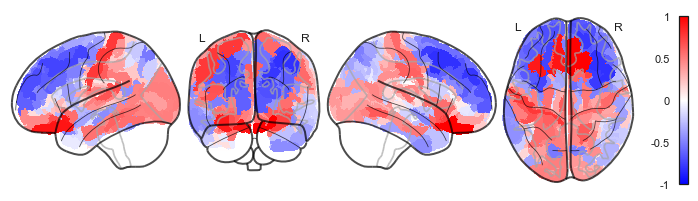

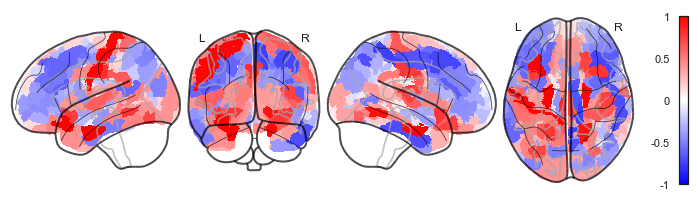

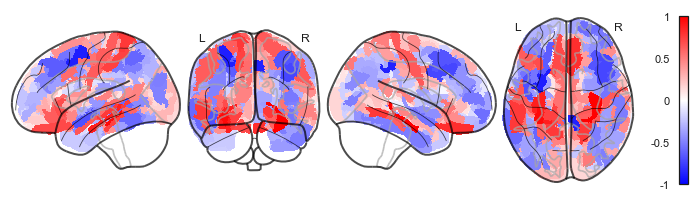

In [35]:
# Save nifti prediction_patterns 
for score_name in scores_thic:
    
    # Define plot folder
    plot_folder = Path(opj('../plots/R1/', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()

    w_thickness = f[score_name]['prediction_pattern_THICKNESS'][:]
    w_thickness = np.squeeze(maxabs_scale(w_thickness[:, None]))

    
    # Define a data frame with these weights and their labels according to Cole
    weights_df = pd.DataFrame({'parcel_label': parcel_labels[:360], 'weights': w_thickness})
    
    ## NIFI FOR NEUROVAULT ## 
    
    # empty data where to map the weights in voxel space
    weight_data = np.zeros((cole_vol_img.shape))
    
    # Left hemisphere
    for (ii, w) in zip(range(1, 181), weights_df.iloc[:180, 1]):
        weight_data[cole_vol_data==ii] = w
        
    # Right hemisphere
    for (ii, w) in zip(range(201, 381), weights_df.iloc[180:, 1]):
        weight_data[cole_vol_data==ii] = w
        
    weights_in_vol = image.new_img_like(cole_vol_img, data=weight_data)
    # Save this to upload to neurovault
    weights_in_vol.to_filename(opj("../images/R1", 
                                   score_name, 
                                   "%s_thickness_prediction_weights.nii.gz" % score_name))
    
    plotting.plot_glass_brain(weights_in_vol, 
                              display_mode='lyrz', 
                              cmap=plt.cm.bwr, 
                              plot_abs=False, 
                              colorbar=True)

### Subcortical volumes

In [81]:
scores_subv =  ['DDisc_AUC_200']

In [82]:
import glob

In [83]:
aparc_aseg = nib.load('../data/aparcaseg_mni_neurovault_23262.nii.gz') 
aparc_aseg_data = aparc_aseg.get_fdata()
aparc_aseg_labels = np.unique(aparc_aseg_data).astype(int)

In [84]:
aparc_aseg_labels

array([   0,    2,    4,    5,    7,    8,   10,   11,   12,   13,   14,
         15,   16,   17,   18,   24,   26,   28,   30,   31,   41,   43,
         44,   46,   47,   49,   50,   51,   52,   53,   54,   58,   60,
         62,   63,   77,   85,  251,  252,  253,  254,  255, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035])

In [85]:
with open('../data/FreeSurferColorLUT.txt') as free_lut:
    lines = free_lut.readlines()

In [86]:
aparc_aseg_labels_names = {}
for line in lines:
    line = line.split()
    try:
        if int(line[0]) in aparc_aseg_labels:
            name = line[1]
            aparc_aseg_labels_names[name] = int(line[0])
    except:
        continue

In [87]:
aparc_aseg_labels_names

{'Unknown': 0,
 'Left-Cerebral-White-Matter': 2,
 'Left-Lateral-Ventricle': 4,
 'Left-Inf-Lat-Vent': 5,
 'Left-Cerebellum-White-Matter': 7,
 'Left-Cerebellum-Cortex': 8,
 'Left-Thalamus-Proper': 10,
 'Left-Caudate': 11,
 'Left-Putamen': 12,
 'Left-Pallidum': 13,
 '3rd-Ventricle': 14,
 '4th-Ventricle': 15,
 'Brain-Stem': 16,
 'Left-Hippocampus': 17,
 'Left-Amygdala': 18,
 'CSF': 24,
 'Left-Accumbens-area': 26,
 'Left-VentralDC': 28,
 'Left-vessel': 30,
 'Left-choroid-plexus': 31,
 'Right-Cerebral-White-Matter': 41,
 'Right-Lateral-Ventricle': 43,
 'Right-Inf-Lat-Vent': 44,
 'Right-Cerebellum-White-Matter': 46,
 'Right-Cerebellum-Cortex': 47,
 'Right-Thalamus-Proper': 49,
 'Right-Caudate': 50,
 'Right-Putamen': 51,
 'Right-Pallidum': 52,
 'Right-Hippocampus': 53,
 'Right-Amygdala': 54,
 'Right-Accumbens-area': 58,
 'Right-VentralDC': 60,
 'Right-vessel': 62,
 'Right-choroid-plexus': 63,
 'WM-hypointensities': 77,
 'Optic-Chiasm': 85,
 'CC_Posterior': 251,
 'CC_Mid_Posterior': 252,
 'CC_C

In [88]:
vol_features_support = pd.read_csv('../results/vol_features_support.csv', sep='\t')

In [89]:
vol_features_support[vol_features_support.included==False].measure.values

array(['Left-WM-hypointensities', 'Right-WM-hypointensities',
       'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities'],
      dtype=object)

In [90]:
np.where(vol_features_support.included==False)

(array([34, 35, 37, 38]),)

In [117]:

score_name = scores_subv[0]
vol_features_weights = f[score_name]['activation_pattern_SUB_VOLUMES'][:]
vol_features_weights = np.squeeze(maxabs_scale(vol_features_weights)[:, None])

vol_pheno_weight={}
for name, weight in zip(vol_features_support.measure[vol_features_support.included].values, vol_features_weights):
    vol_pheno_weight[name] = weight


In [118]:
for ii in np.argsort(vol_features_weights):
    print(vol_features_weights[ii], "", vol_features_support.measure[vol_features_support.included].values[ii])

-1.0  CC_Anterior
-0.8799147351729353  Optic-Chiasm
-0.809735672907692  Right-Pallidum
-0.7063678330669523  Left-Pallidum
-0.7023822667093965  CC_Posterior
-0.6493089743234042  Left-choroid-plexus
-0.6236607500281115  Right-choroid-plexus
-0.5532816647604955  Left-Putamen
-0.4674672772956114  Left-Accumbens-area
-0.32654106698136015  rhCorticalWhiteMatterVol
-0.3214717889579461  5th-Ventricle
-0.32086311186396754  CorticalWhiteMatterVol
-0.314650938082719  lhCorticalWhiteMatterVol
-0.31166654401733984  Brain-Stem
-0.2986715653056251  Right-Putamen
-0.25388922883876935  SubCortGrayVol
-0.25332385114836714  Right-VentralDC
-0.23515373155634078  Left-Inf-Lat-Vent
-0.23468385761220162  non-WM-hypointensities
-0.21657631377424497  Right-Cerebellum-White-Matter
-0.21290818085159102  Left-VentralDC
-0.19161127318784033  Right-Thalamus-Proper
-0.1594520533711388  CC_Mid_Anterior
-0.1441701735743226  Left-vessel
-0.10902636542540531  Left-Cerebellum-White-Matter
-0.08581080841695679  Right-Caud

In [138]:
print(pd.DataFrame({'name':list(vol_pheno_weight.keys()), 'value':list(vol_pheno_weight.values())}).sort_values(by='value').to_latex())

\begin{tabular}{llr}
\toprule
{} &                           name &     value \\
\midrule
40 &                    CC\_Anterior & -1.000000 \\
35 &                   Optic-Chiasm & -0.879915 \\
25 &                 Right-Pallidum & -0.809736 \\
7  &                  Left-Pallidum & -0.706368 \\
36 &                   CC\_Posterior & -0.702382 \\
17 &            Left-choroid-plexus & -0.649309 \\
31 &           Right-choroid-plexus & -0.623661 \\
6  &                   Left-Putamen & -0.553282 \\
14 &            Left-Accumbens-area & -0.467467 \\
48 &       rhCorticalWhiteMatterVol & -0.326541 \\
32 &                  5th-Ventricle & -0.321472 \\
49 &         CorticalWhiteMatterVol & -0.320863 \\
47 &       lhCorticalWhiteMatterVol & -0.314651 \\
10 &                     Brain-Stem & -0.311667 \\
24 &                  Right-Putamen & -0.298672 \\
50 &                 SubCortGrayVol & -0.253889 \\
29 &                Right-VentralDC & -0.253324 \\
1  &              Left-Inf-Lat-Vent & -0.

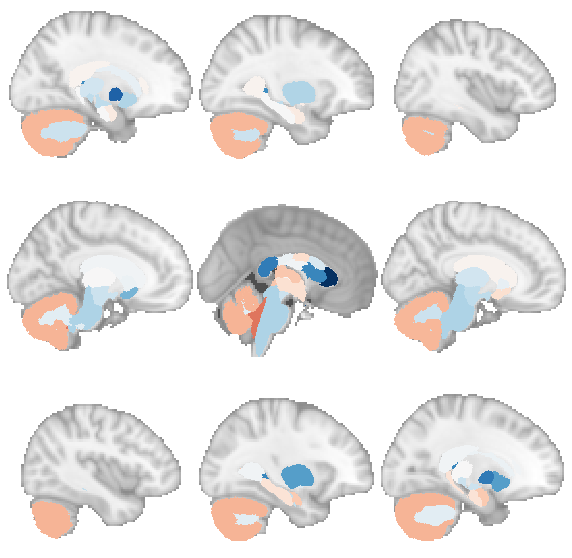

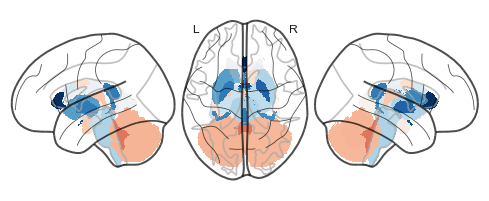

In [93]:
# A few features are discarded because they are mainly the same

for score_name in scores_subv:
    vol_features_weights = f[score_name]['activation_pattern_SUB_VOLUMES'][:]
    vol_features_weights = np.squeeze(maxabs_scale(vol_features_weights)[:, None])
    
    vol_pheno_weight={}
    for name, weight in zip(vol_features_support.measure[vol_features_support.included].values, vol_features_weights):
        vol_pheno_weight[name] = weight
        
    #map each index with a weight
    index_map = {}
    name_map = {}
    for name, beta in vol_pheno_weight.items():
        try:
            index_map[aparc_aseg_labels_names[name]] = beta
            name_map[name] = beta
        except:
            #print(name)
            continue
            
    # Create empty array with the aparc_aseg where we are going to map the weights
    pheno_img_data = np.zeros(aparc_aseg.shape)

    # fill this array with the weights
    for index, weight in index_map.items():
        pheno_img_data[aparc_aseg_data==index] = weight

    # Create the image
    pheno_img = image.new_img_like(aparc_aseg, data=pheno_img_data)
    
     Save this image for neuroVault
    pheno_img.to_filename(opj("../images/R1", 
                              score_name, 
                              "%s_volume_activation_weights.nii.gz" % score_name))
    
    fig, axs = plt.subplots(nrows=3, figsize=(10,10))
    plotting.plot_stat_map(pheno_img, 
                           cmap=plt.cm.RdBu_r,
                           colorbar=False,
                           annotate=False,
                           symmetric_cbar=True,
                           display_mode="x", 
                           vmax=1,
                           cut_coords=(40, 30, 20), 
                           axes=axs[0])
    
    plotting.plot_stat_map(pheno_img, 
                           cmap=plt.cm.RdBu_r,
                           colorbar=False,
                           annotate=False,
                           symmetric_cbar=True,
                           display_mode="x", 
                           vmax=1,
                           cut_coords=(10, 0, -10), 
                           axes=axs[1])
    
    plotting.plot_stat_map(pheno_img, 
                           cmap=plt.cm.RdBu_r,
                           annotate=False,
                           colorbar=False,
                           symmetric_cbar=True,
                           display_mode="x", 
                           vmax=1,
                           cut_coords=(-20, -30, -40),
                           axes=axs[2])
    
    
    plt.savefig(opj("../plots/R1/neurophenotypes", score_name, 'volumetric_features.png'), dpi=300)
    plt.savefig(opj("../plots/R1/neurophenotypes", score_name, 'volumetric_features.svg'), dpi=300)


    # Plot this image as a glass brain
    plotting.plot_glass_brain(pheno_img, 
                              colorbar=False, 
                              plot_abs=False, 
                              cmap=plt.cm.RdBu_r, 
                              display_mode='lzr', 
                              symmetric_cbar=True)
    


In [ ]:
# Prediction patterns

for score_name in scores_subv:
    vol_features_weights = f[score_name]['prediction_pattern_SUB_VOLUMES'][:]
    vol_features_weights = np.squeeze(maxabs_scale(vol_features_weights)[:, None])
    
    vol_pheno_weight={}
    for name, weight in zip(vol_features_support.measure[vol_features_support.included].values, vol_features_weights):
        vol_pheno_weight[name] = weight
        
    #map each index with a weight
    index_map = {}
    name_map = {}
    for name, beta in vol_pheno_weight.items():
        try:
            index_map[aparc_aseg_labels_names[name]] = beta
            name_map[name] = beta
        except:
            #print(name)
            continue
            
    # Create empty array with the aparc_aseg where we are going to map the weights
    pheno_img_data = np.zeros(aparc_aseg.shape)

    # fill this array with the weights
    for index, weight in index_map.items():
        pheno_img_data[aparc_aseg_data==index] = weight

    # Create the image
    pheno_img = image.new_img_like(aparc_aseg, data=pheno_img_data)
    
    # Save this image for neuroVault
    #pheno_img.to_filename(opj("../images/R1", 
                            #  score_name, 
                             # "%s_volume_prediction_weights.nii.gz" % score_name))


    # Plot this image as a glass brain
    plotting.plot_glass_brain(pheno_img, 
                              colorbar=False, 
                              plot_abs=False, 
                              cmap=plt.cm.RdBu_r, 
                              display_mode='lzr', 
                              symmetric_cbar=True)

# CORRELATION BETWEEN PHENOTYPES (FIGURE S3)

/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


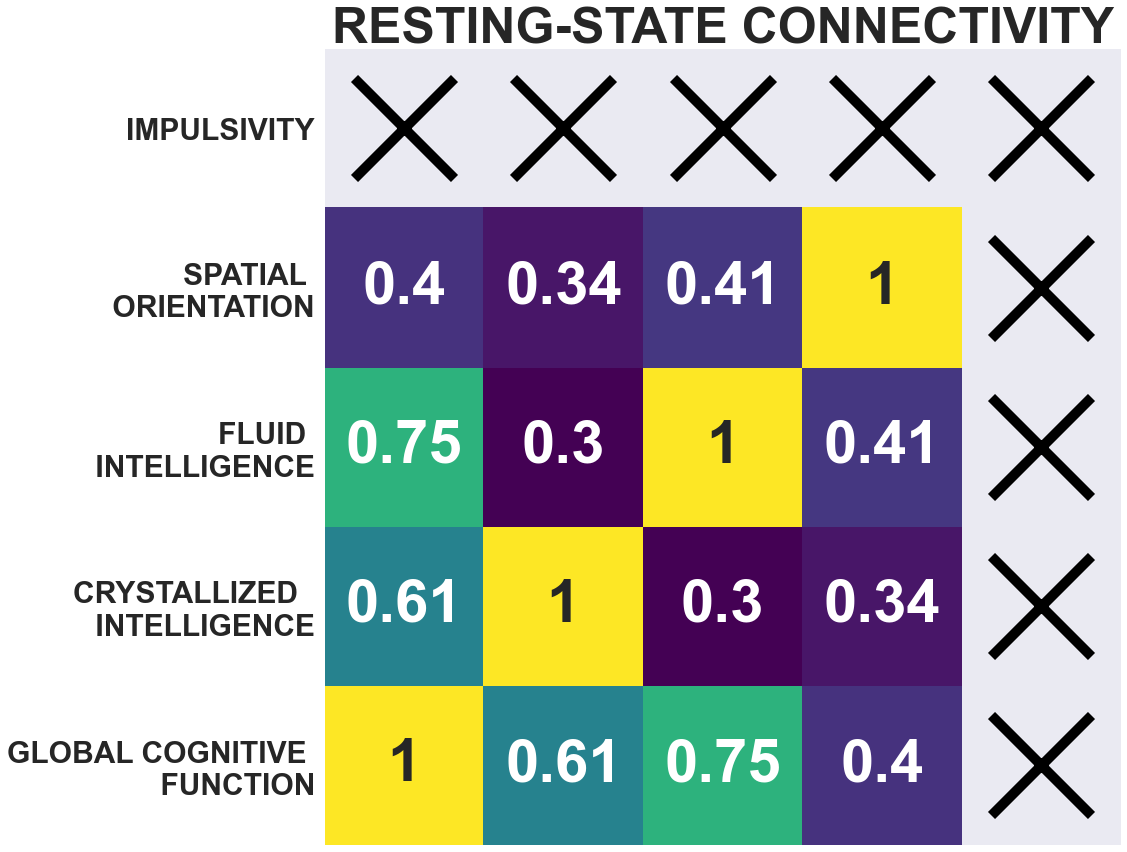

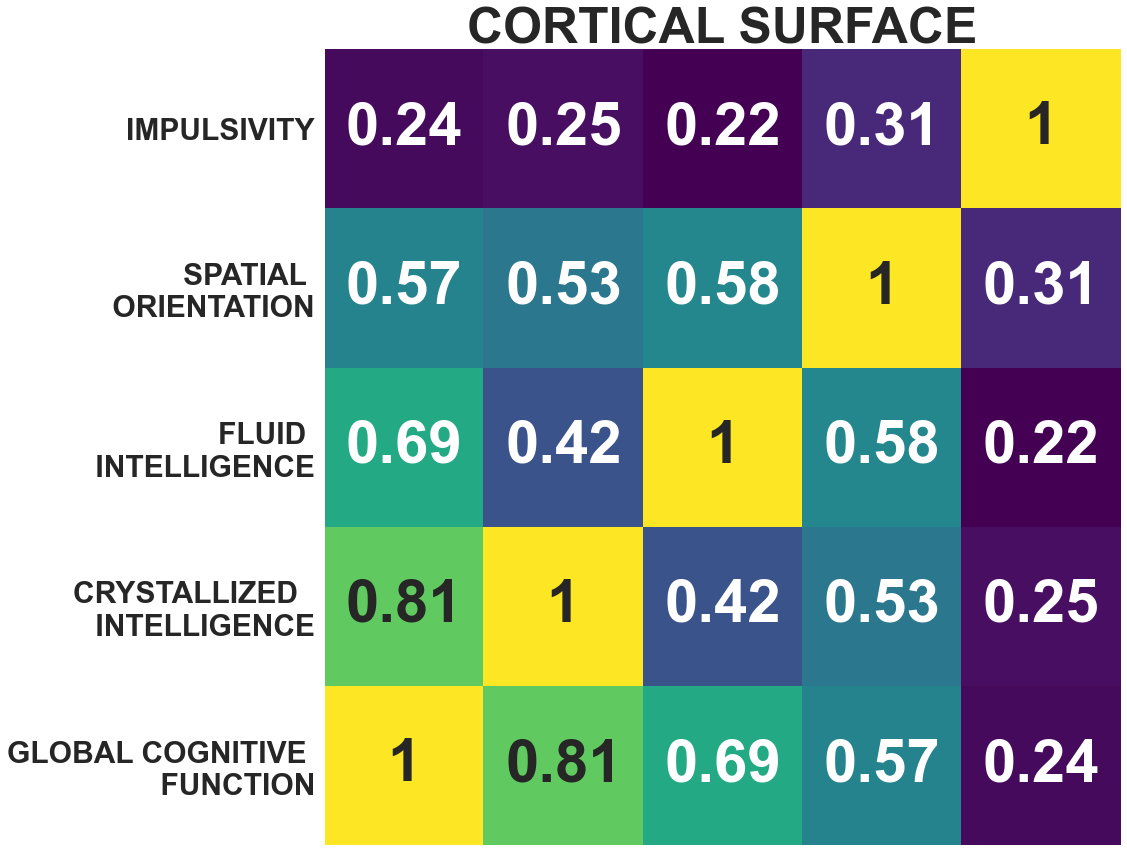

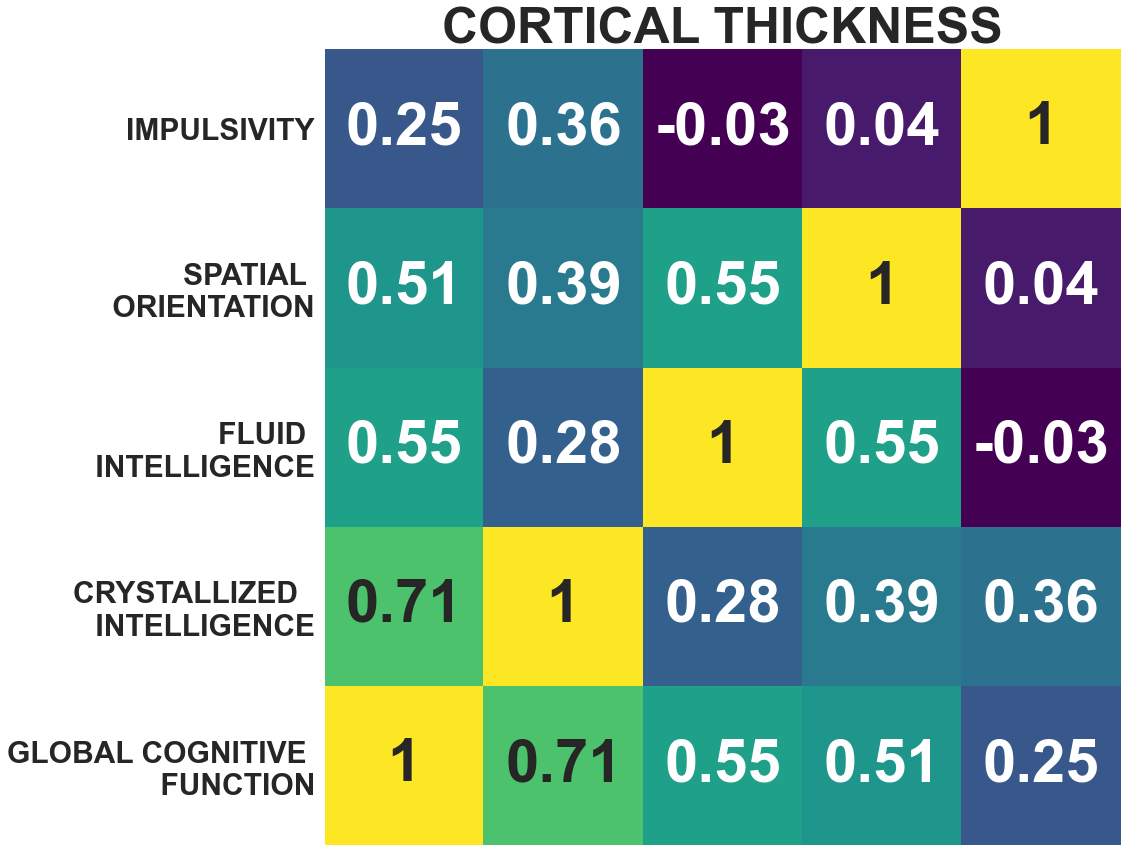

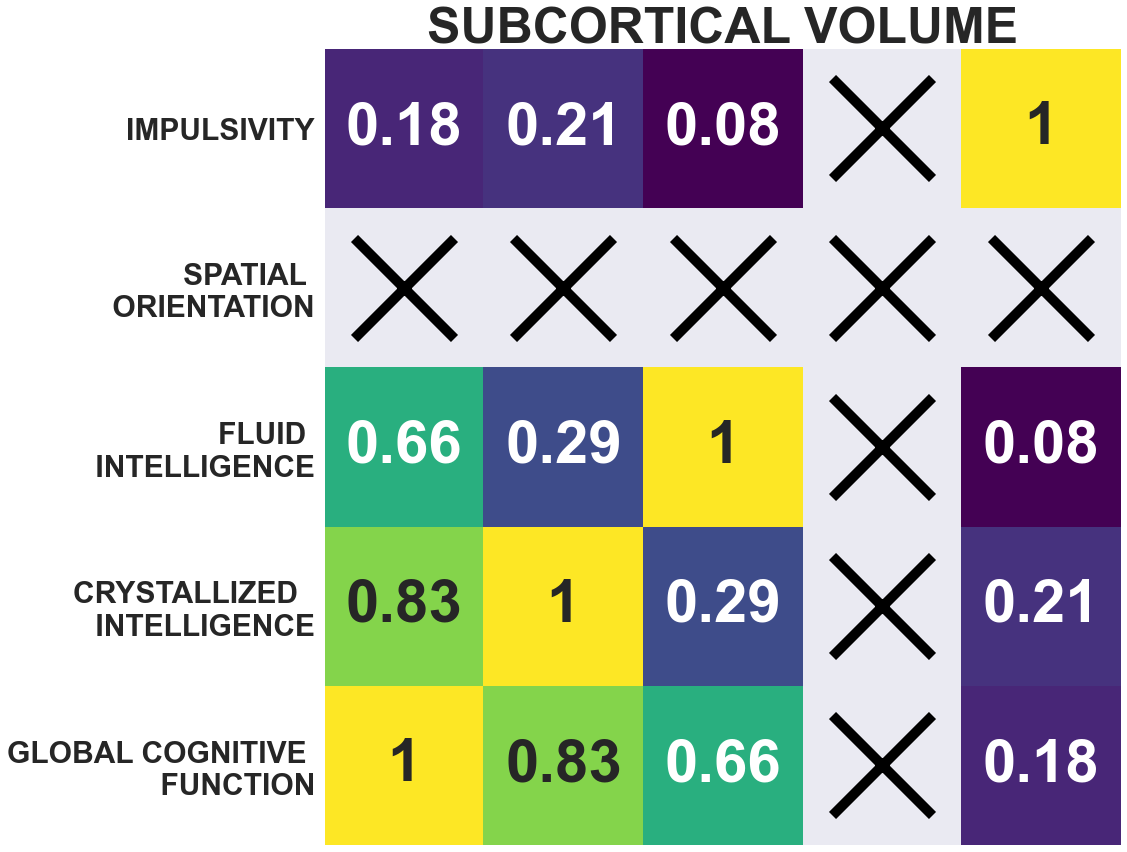

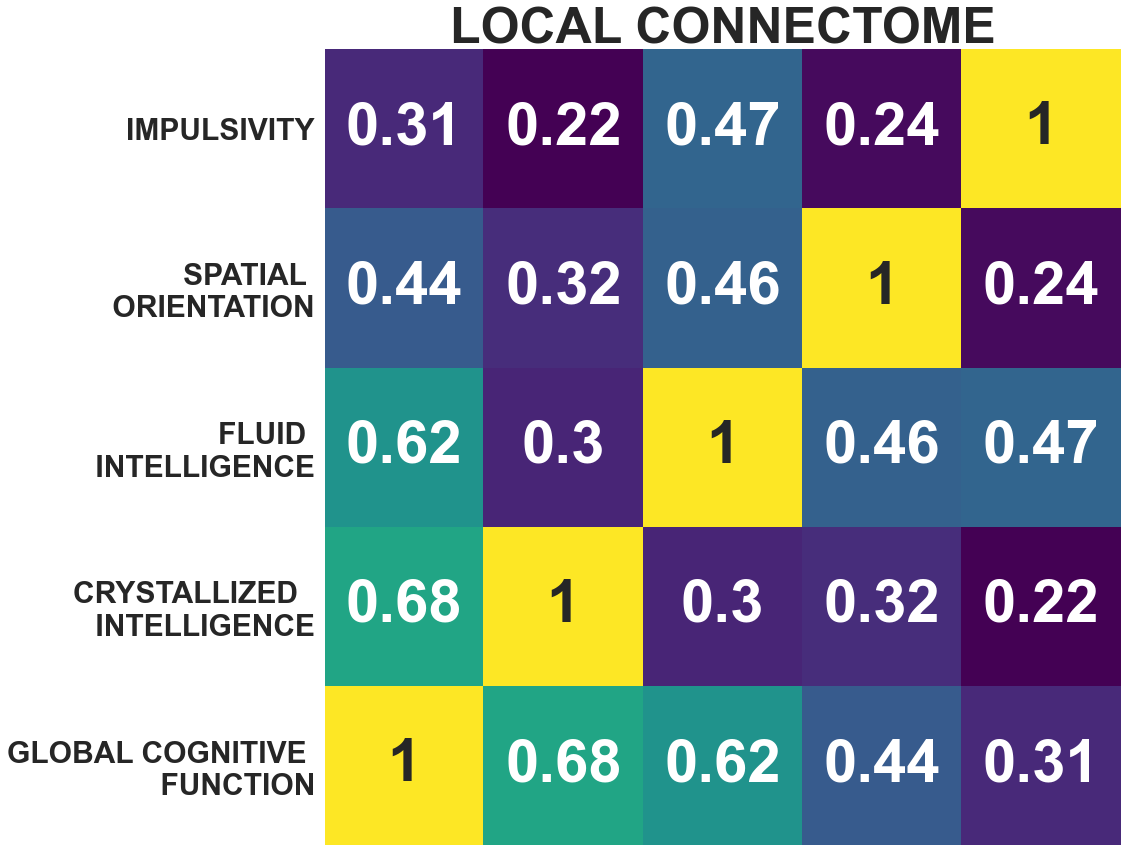

In [50]:
for mod in ['CONNECTOME', 'SURFACE', 'THICKNESS', 'SUB_VOLUMES', 'LOCAL_CONN']:

    if mod=='CONNECTOME':
        mod_name = 'RESTING-STATE CONNECTIVITY'
    elif mod=='LOCAL_CONN':
        mod_name =   'LOCAL CONNECTOME'
    elif mod == 'SUB_VOLUMES':
        mod_name = 'SUBCORTICAL VOLUME'
    elif mod == 'SURFACE':
        mod_name = 'CORTICAL SURFACE'
    elif mod == 'THICKNESS':
         mod_name = 'CORTICAL THICKNESS'
    else:
        continue

    fig, ax = plt.subplots(figsize=(24, 12))
    cor_mat = np.corrcoef(np.vstack([f['CogTotalComp_Unadj']['prediction_pattern_' + mod][:], 
                                     f['CogCrystalComp_Unadj']['prediction_pattern_' + mod][:],
                                     f['CogFluidComp_Unadj']['prediction_pattern_' + mod][:],
                                     f['VSPLOT_TC']['prediction_pattern_' + mod][:],
                                     f['DDisc_AUC_200']['prediction_pattern_' + mod][:]]))
    sns.heatmap(np.round(cor_mat,2), 
                cmap=plt.cm.viridis, 
                cbar=False,
                annot=True, 
                square=True, 
                annot_kws={'size':60, 'weight':'bold'}, 
                ax=ax)
    
    labels = ['GLOBAL COGNITIVE \n FUNCTION', 
              'CRYSTALLIZED  \n INTELLIGENCE',
              'FLUID \n INTELLIGENCE', 
              'SPATIAL \n ORIENTATION',
             'IMPULSIVITY']
    ax.set_yticks([0.5, 1.5,2.5, 3.5, 4.5])
    ax.set_yticklabels(labels=labels, size=30, rotation=0, weight='bold')
    
    ax.set_xticks([])
    ax.set_ylim([0, 5.])
    ax.set_title(mod_name, size=50, weight='bold')
    
    cor_mat_masked = np.ma.array(cor_mat, mask=np.isnan(cor_mat))
    for (x, y) in np.argwhere(cor_mat_masked.mask):
        ax.scatter(x+0.5, y+0.5, marker="x", color="black", s=10000, lw=10)
    
    plt.tight_layout()
    plt.savefig(opj("../plots/R1/neurophenotypes",'corrs_phen_chan_%s.svg') % mod, dpi=300)
    plt.savefig(opj('../plots/R1/neurophenotypes','corrs_phen_chan_%s.png') % mod, dpi=300)

# FOR THE REVIEWER 1: See phenotypes from the cortical surfaces and thickness using directly the freesurfer information to check that we get similar patterns

In [67]:
f_data = h5py.File("../data/final_data_R1.hdf5", "r") 

In [68]:
subjects = f_data['subjects'][:]
YY_domain_cognition = f_data['YY_domain_cognition'][:]
intracv_var = f_data['intracv_feature'][:]
f_data.close()

In [69]:
unrestricted_dat = pd.read_excel("../data/unrestricted_jraserod_8_16_2019_12_4_12.xlsx")

In [70]:
columns = pd.merge(unrestricted_dat, pd.DataFrame({'Subject':subjects}), on="Subject").columns

In [71]:
# This are the names in unrestricted hcp data the areas in FS parcellation (Desikan)
columns[322:390]

Index(['FS_L_Bankssts_Area', 'FS_L_Caudalanteriorcingulate_Area',
       'FS_L_Caudalmiddlefrontal_Area', 'FS_L_Cuneus_Area',
       'FS_L_Entorhinal_Area', 'FS_L_Fusiform_Area',
       'FS_L_Inferiorparietal_Area', 'FS_L_Inferiortemporal_Area',
       'FS_L_Isthmuscingulate_Area', 'FS_L_Lateraloccipital_Area',
       'FS_L_Lateralorbitofrontal_Area', 'FS_L_Lingual_Area',
       'FS_L_Medialorbitofrontal_Area', 'FS_L_Middletemporal_Area',
       'FS_L_Parahippocampal_Area', 'FS_L_Paracentral_Area',
       'FS_L_Parsopercularis_Area', 'FS_L_Parsorbitalis_Area',
       'FS_L_Parstriangularis_Area', 'FS_L_Pericalcarine_Area',
       'FS_L_Postcentral_Area', 'FS_L_Posteriorcingulate_Area',
       'FS_L_Precentral_Area', 'FS_L_Precuneus_Area',
       'FS_L_Rostralanteriorcingulate_Area', 'FS_L_Rostralmiddlefrontal_Area',
       'FS_L_Superiorfrontal_Area', 'FS_L_Superiorparietal_Area',
       'FS_L_Superiortemporal_Area', 'FS_L_Supramarginal_Area',
       'FS_L_Frontalpole_Area', 'FS_L_Temp

In [72]:
# This are the names in unrestricted hcp data for the thicknessess in FS parcellation
columns[254:322]

Index(['FS_L_Bankssts_Thck', 'FS_L_Caudalanteriorcingulate_Thck',
       'FS_L_Caudalmiddlefrontal_Thck', 'FS_L_Cuneus_Thck',
       'FS_L_Entorhinal_Thck', 'FS_L_Fusiform_Thck',
       'FS_L_Inferiorparietal_Thck', 'FS_L_Inferiortemporal_Thck',
       'FS_L_Isthmuscingulate_Thck', 'FS_L_Lateraloccipital_Thck',
       'FS_L_Lateralorbitofrontal_Thck', 'FS_L_Lingual_Thck',
       'FS_L_Medialorbitofrontal_Thck', 'FS_L_Middletemporal_Thck',
       'FS_L_Parahippocampal_Thck', 'FS_L_Paracentral_Thck',
       'FS_L_Parsopercularis_Thck', 'FS_L_Parsorbitalis_Thck',
       'FS_L_Parstriangularis_Thck', 'FS_L_Pericalcarine_Thck',
       'FS_L_Postcentral_Thck', 'FS_L_Posteriorcingulate_Thck',
       'FS_L_Precentral_Thck', 'FS_L_Precuneus_Thck',
       'FS_L_Rostralanteriorcingulate_Thck', 'FS_L_Rostralmiddlefrontal_Thck',
       'FS_L_Superiorfrontal_Thck', 'FS_L_Superiorparietal_Thck',
       'FS_L_Superiortemporal_Thck', 'FS_L_Supramarginal_Thck',
       'FS_L_Frontalpole_Thck', 'FS_L_Temp

In [73]:
X_surf_fs = pd.merge(unrestricted_dat, pd.DataFrame({'Subject':subjects}), on="Subject").iloc[:, range(322,390)].values
X_thic_fs = pd.merge(unrestricted_dat, pd.DataFrame({'Subject':subjects}), on="Subject").iloc[:, range(254,322)].values

In [74]:
X_surf_fs

array([[1078.,  983., 3808., ...,  500.,  384., 2267.],
       [ 908.,  588., 2347., ...,  412.,  375., 2385.],
       [1112.,  731., 2603., ...,  410.,  421., 2578.],
       ...,
       [ 836.,  704., 2209., ...,  449.,  288., 2091.],
       [1073.,  524., 2153., ...,  435.,  386., 2821.],
       [1309.,  835., 2850., ...,  495.,  460., 2731.]])

In [75]:
X_thic_fs

array([[2.733, 2.682, 2.765, ..., 3.579, 3.147, 3.278],
       [2.713, 3.253, 2.795, ..., 4.026, 2.819, 3.002],
       [2.532, 2.588, 2.612, ..., 3.102, 2.532, 2.947],
       ...,
       [2.693, 3.102, 2.595, ..., 4.024, 2.86 , 3.149],
       [2.755, 2.763, 2.731, ..., 3.749, 2.996, 3.202],
       [2.584, 2.809, 2.71 , ..., 3.656, 2.618, 2.983]])

In [76]:
# Use global cognition only
y = YY_domain_cognition[:,0]

In [77]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(intracv_var[:, None], y)

# Remove ICV effect from the entire response variable
y_adj = y - linReg.predict(intracv_var[:, None]) + linReg.intercept_

In [78]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

# LASSO-PCR
pip = make_pipeline(VarianceThreshold(), StandardScaler(), PCA(), LassoCV(max_iter=1e6, cv=5, random_state=0))

In [79]:
pca = PCA()
ss = StandardScaler()
cov_surf_fs = np.cov(ss.fit_transform(X_surf_fs).T)

pip.fit(X_surf_fs, y_adj)

a_surf_fs = cov_surf_fs @ pip.named_steps['pca'].inverse_transform(pip.named_steps['lassocv'].coef_)

In [80]:
pca = PCA()
ss = StandardScaler()
cov_thic_fs = np.cov(ss.fit_transform(X_thic_fs).T)

pip.fit(X_thic_fs, y_adj)

a_thic_fs = cov_thic_fs @ pip.named_steps['pca'].inverse_transform(pip.named_steps['lassocv'].coef_)

In [81]:
aparc_aseg_img = image.load_img("../data/aparcaseg_mni_neurovault_23262.nii.gz")

In [82]:
np.unique(aparc_aseg_img.get_fdata())

array([0.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 8.000e+00,
       1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01,
       1.600e+01, 1.700e+01, 1.800e+01, 2.400e+01, 2.600e+01, 2.800e+01,
       3.000e+01, 3.100e+01, 4.100e+01, 4.300e+01, 4.400e+01, 4.600e+01,
       4.700e+01, 4.900e+01, 5.000e+01, 5.100e+01, 5.200e+01, 5.300e+01,
       5.400e+01, 5.800e+01, 6.000e+01, 6.200e+01, 6.300e+01, 7.700e+01,
       8.500e+01, 2.510e+02, 2.520e+02, 2.530e+02, 2.540e+02, 2.550e+02,
       1.000e+03, 1.001e+03, 1.002e+03, 1.003e+03, 1.004e+03, 1.005e+03,
       1.006e+03, 1.007e+03, 1.008e+03, 1.009e+03, 1.010e+03, 1.011e+03,
       1.012e+03, 1.013e+03, 1.014e+03, 1.015e+03, 1.016e+03, 1.017e+03,
       1.018e+03, 1.019e+03, 1.020e+03, 1.021e+03, 1.022e+03, 1.023e+03,
       1.024e+03, 1.025e+03, 1.026e+03, 1.027e+03, 1.028e+03, 1.029e+03,
       1.030e+03, 1.031e+03, 1.032e+03, 1.033e+03, 1.034e+03, 1.035e+03,
       2.000e+03, 2.001e+03, 2.002e+03, 2.003e+03, 

In [83]:
columns[322:356]

Index(['FS_L_Bankssts_Area', 'FS_L_Caudalanteriorcingulate_Area',
       'FS_L_Caudalmiddlefrontal_Area', 'FS_L_Cuneus_Area',
       'FS_L_Entorhinal_Area', 'FS_L_Fusiform_Area',
       'FS_L_Inferiorparietal_Area', 'FS_L_Inferiortemporal_Area',
       'FS_L_Isthmuscingulate_Area', 'FS_L_Lateraloccipital_Area',
       'FS_L_Lateralorbitofrontal_Area', 'FS_L_Lingual_Area',
       'FS_L_Medialorbitofrontal_Area', 'FS_L_Middletemporal_Area',
       'FS_L_Parahippocampal_Area', 'FS_L_Paracentral_Area',
       'FS_L_Parsopercularis_Area', 'FS_L_Parsorbitalis_Area',
       'FS_L_Parstriangularis_Area', 'FS_L_Pericalcarine_Area',
       'FS_L_Postcentral_Area', 'FS_L_Posteriorcingulate_Area',
       'FS_L_Precentral_Area', 'FS_L_Precuneus_Area',
       'FS_L_Rostralanteriorcingulate_Area', 'FS_L_Rostralmiddlefrontal_Area',
       'FS_L_Superiorfrontal_Area', 'FS_L_Superiorparietal_Area',
       'FS_L_Superiortemporal_Area', 'FS_L_Supramarginal_Area',
       'FS_L_Frontalpole_Area', 'FS_L_Temp

In [84]:
fs_file = open("../data/FreeSurferColorLUT.txt", "r")

In [85]:
fs_file_lines = []
for line in fs_file.readlines():
    fs_file_lines.append(line.strip())
    

In [86]:
len(fs_file_lines)

1436

In [87]:
fs_fut_dict = {}
for line in fs_file_lines[446:518]:
    line_split = line.split(" ")
    
    if len(line_split) > 10: 
        fs_fut_dict[line_split[4]] = line_split[0]


In [88]:
fs_fut_dict

{'ctx-lh-bankssts': '1001',
 'ctx-lh-caudalanteriorcingulate': '1002',
 'ctx-lh-caudalmiddlefrontal': '1003',
 'ctx-lh-corpuscallosum': '1004',
 'ctx-lh-cuneus': '1005',
 'ctx-lh-entorhinal': '1006',
 'ctx-lh-fusiform': '1007',
 'ctx-lh-inferiorparietal': '1008',
 'ctx-lh-inferiortemporal': '1009',
 'ctx-lh-isthmuscingulate': '1010',
 'ctx-lh-lateraloccipital': '1011',
 'ctx-lh-lateralorbitofrontal': '1012',
 'ctx-lh-lingual': '1013',
 'ctx-lh-medialorbitofrontal': '1014',
 'ctx-lh-middletemporal': '1015',
 'ctx-lh-parahippocampal': '1016',
 'ctx-lh-paracentral': '1017',
 'ctx-lh-parsopercularis': '1018',
 'ctx-lh-parsorbitalis': '1019',
 'ctx-lh-parstriangularis': '1020',
 'ctx-lh-pericalcarine': '1021',
 'ctx-lh-postcentral': '1022',
 'ctx-lh-posteriorcingulate': '1023',
 'ctx-lh-precentral': '1024',
 'ctx-lh-precuneus': '1025',
 'ctx-lh-rostralanteriorcingulate': '1026',
 'ctx-lh-rostralmiddlefrontal': '1027',
 'ctx-lh-superiorfrontal': '1028',
 'ctx-lh-superiorparietal': '1029',
 '

In [89]:
hcp_fs = []
for name in columns[range(322,390)]:
    name_roi = name.split("_")[2].lower()
    hem = name.split("_")[1].lower()
    
    if hem == "l":
        hem= "lh"
    elif hem == "r":
        hem = "rh"
        
    name_roi = hem + "-" + name_roi
    
    for key, value in fs_fut_dict.items():
        if name_roi in key:
            hcp_fs.append(int(value))
        
    

In [90]:
# Map weights to parcellation to be able to plot them
a_surf_fs_data = np.zeros_like(aparc_aseg_img.get_fdata())
for ix, w in zip(hcp_fs, a_surf_fs):
    a_surf_fs_data[aparc_aseg_img.get_fdata()==ix] = w

a_surf_img = image.new_img_like(aparc_aseg_img, data=a_surf_fs_data)

In [91]:
# Map weights to parcellation to be able to plot them
a_thic_fs_data = np.zeros_like(aparc_aseg_img.get_fdata())
for ix, w in zip(hcp_fs, a_thic_fs):
    a_thic_fs_data[aparc_aseg_img.get_fdata()==ix] = w

a_thic_img = image.new_img_like(aparc_aseg_img, data=a_thic_fs_data)

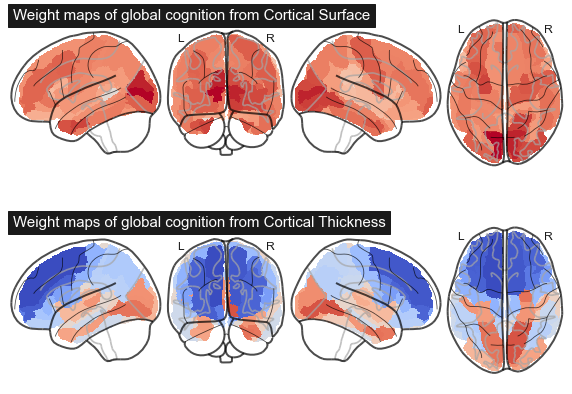

In [100]:
fig, axs = plt.subplots(nrows=2, figsize=(10,7))

plotting.plot_glass_brain(a_surf_img, 
                          plot_abs=False, 
                          cmap=plt.cm.coolwarm, 
                          display_mode="lyrz",
                          title="Weight maps of global cognition from Cortical Surface",
                          axes=axs[0])

plotting.plot_glass_brain(a_thic_img, 
                          plot_abs=False, 
                          cmap=plt.cm.coolwarm, 
                          display_mode="lyrz",
                          title="Weight maps of global cognition from Cortical Thickness",
                          axes=axs[1])
plt.savefig("../plots/R1/ct_csa_maps_freesurfer_glob_cog.png")

In [315]:
from nilearn import datasets
from nilearn.surface import vol_to_surf

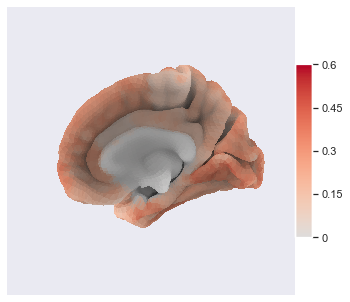

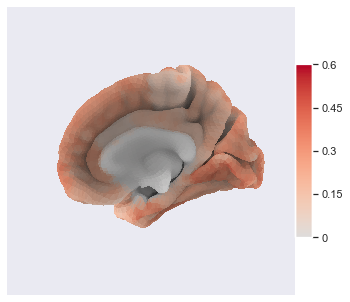

In [330]:
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage()['pial_right'],  
                            vol_to_surf(a_surf_img, datasets.fetch_surf_fsaverage()['pial_right']), 
                            hemi='left', 
                            cmap=plt.cm.coolwarm, 
                            bg_map=datasets.fetch_surf_fsaverage()['sulc_right'], 
                            bg_on_data=True,
                            view="lateral")

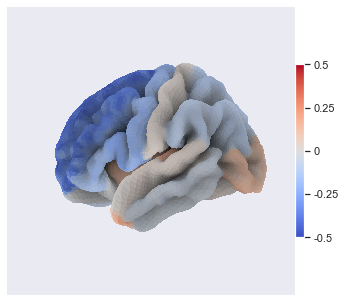

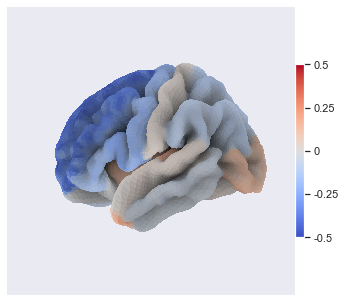

In [328]:
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage()['pial_left'],  
                            vol_to_surf(a_thic_img, datasets.fetch_surf_fsaverage()['pial_left']), 
                            hemi='left', cmap=plt.cm.coolwarm, 
                            bg_map=datasets.fetch_surf_fsaverage()['sulc_left'], 
                            bg_on_data=True,
                            view="lateral")

plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage()['pial_left'],  
                            vol_to_surf(a_thic_img, datasets.fetch_surf_fsaverage()['pial_left']), 
                            hemi='left', cmap=plt.cm.coolwarm, 
                            bg_map=datasets.fetch_surf_fsaverage()['sulc_left'], 
                            bg_on_data=True,
                            view="lateral")